In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from matplotlib_venn import venn2
from nltk.probability import FreqDist
from scipy.stats import spearmanr
from matplotlib import gridspec

import plotly.graph_objs as go
import pandas as pd
import numpy as np
import plotly.offline as py
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import tensorflow as tf
# from transformers import *
# import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import tensorflow.keras.backend as K

from tqdm import tqdm
import os

<h1> Reading data </h1>

In [7]:
print('Reading data...')
train_data = pd.read_csv('google-quest-challenge/train.csv')
test_data = pd.read_csv('google-quest-challenge/test.csv')
sample_submission = pd.read_csv('google-quest-challenge/sample_submission.csv')
print('Reading data completed')

Reading data...
Reading data completed


In [8]:
print('Size of train_data', train_data.shape)
print('Size of test_data', test_data.shape)
print('Size of sample_submission', sample_submission.shape)

Size of train_data (6079, 41)
Size of test_data (476, 11)
Size of sample_submission (476, 31)


In [9]:
train_data.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [10]:
test_data.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


In [11]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,...,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,...,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,...,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,...,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,...,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


In [12]:
train_data.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [13]:
train_data['question_body_critical'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0.333333
1       1.000000
2       0.666667
3       0.666667
4       0.666667
          ...   
6074    0.777778
6075    0.777778
6076    0.555556
6077    0.444444
6078    1.000000
Name: question_body_critical, Length: 6079, dtype: float64>

In [14]:
targets = list(sample_submission.columns[1:])
print(len(targets))
targets

30


['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

<h3> Statistical overview of the Data </h3>

In [15]:
train_data[targets].describe()


,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,0.892663,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,0.004469,...,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,0.132047,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,0.045782,...,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,0.777778,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,0.000000,...,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,0.888889,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,0.000000,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,0.000000,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
answer_well_written,0,0.0
question_multi_intent,0,0.0
question_interestingness_others,0,0.0
question_has_commonly_accepted_answer,0,0.0
question_fact_seeking,0,0.0


In [17]:
# checking missing data
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

,Total,Percent
host,0,0.0
category,0,0.0
url,0,0.0
answer_user_page,0,0.0
answer_user_name,0,0.0


- No Missing Values present in Train Data and Test Data

<h1> Exploratory Data Analysis </h1>

## Distribution of Host(from which website Question & Answers collected)

In [18]:
temp = train_data["host"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Distribution of hosts in Training data')

In [19]:
temp = test_data["host"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Distribution of hosts in test data')

## Conclusion
- In Training DataSet Stackoverflow.com from which most website Question & Answers collected over 20.6% and 1253 datapoint.
- english.stackexchange.com has contributed 3.77 % and 229 in DataSet.
- In Testing DataSet Stackoverflow.com from which most website Question & Answers collected over 21.6% and 103 datapoint.
- english.stackexchange.com has contributed 4.2 % and 20 in DataSet.

## Distribution of categories

In [20]:
temp = train_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of categories in training data in % ",
    xaxis=dict(
        title='category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')


In [ ]:
temp = test_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of categories in test data in % ",
    xaxis=dict(
        title='category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')

## Conclusion Distribution of categories in training data in % and Testting Data 
- Distribution of Categories is a Categorical Data conatin Technology,StackoverFlow,Culture , Science and Life arts
- Technology and Stackoverflow has contributed Maximum in training as well as Testing Data set
- Technology = 40% in Training data set and 42.85 % in testing Data set.


## Distribution of Target variables

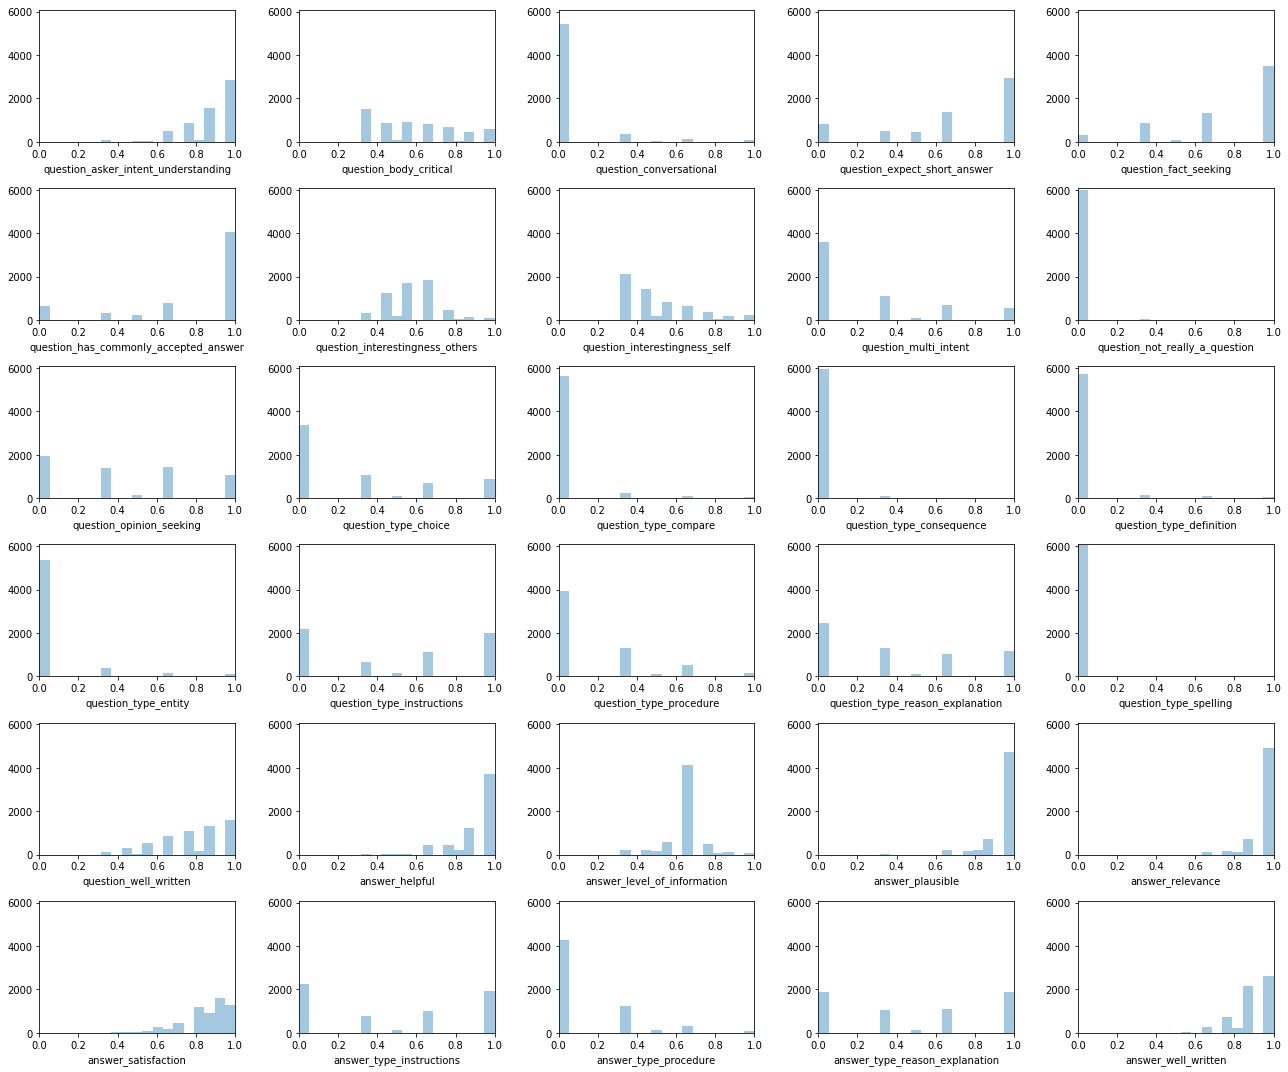

In [ ]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(targets):
    ax = axes[i]
    sns.distplot(train_data[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

##  Venn Diagram(Common Features values in training and test data)¶

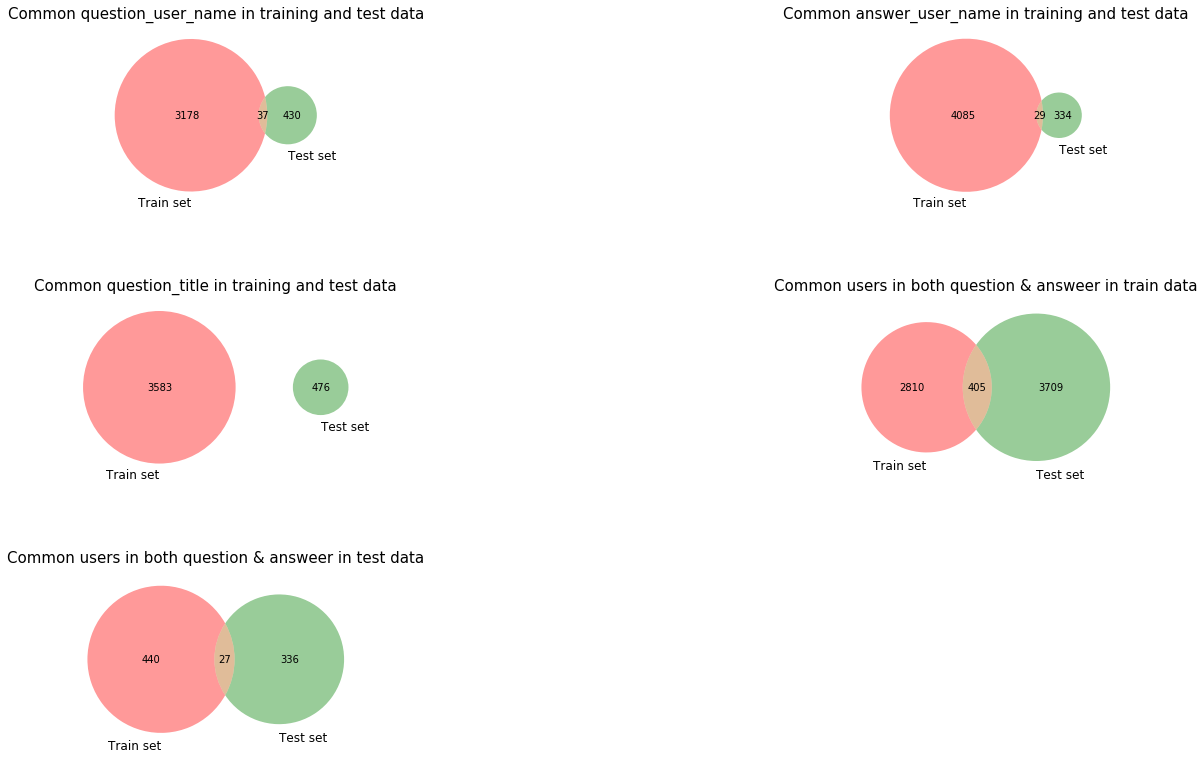

In [ ]:
plt.figure(figsize=(23,13))

plt.subplot(321)
venn2([set(train_data.question_user_name.unique()), set(test_data.question_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_user_name in training and test data", fontsize=15)

plt.subplot(322)
venn2([set(train_data.answer_user_name.unique()), set(test_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common answer_user_name in training and test data", fontsize=15)

plt.subplot(323)
venn2([set(train_data.question_title.unique()), set(test_data.question_title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_title in training and test data", fontsize=15)

plt.subplot(324)
venn2([set(train_data.question_user_name.unique()), set(train_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common users in both question & answeer in train data", fontsize=15)

plt.subplot(325)
venn2([set(test_data.question_user_name.unique()), set(test_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common users in both question & answeer in test data", fontsize=15)

plt.subplots_adjust(wspace = 0.5, hspace = 0.5,
                    top = 0.9)
plt.show()
from matplotlib_venn import venn2

## Conclusion
- Above Ven diagram shows that common feature in training and testing Data set
- There no common question_title present in traning and testing dataset.i.e all question title is unique in testing dataset.
- The Most common Feature  present in training as well as testing is answer_user_name is 405

## Distribution for Question Title

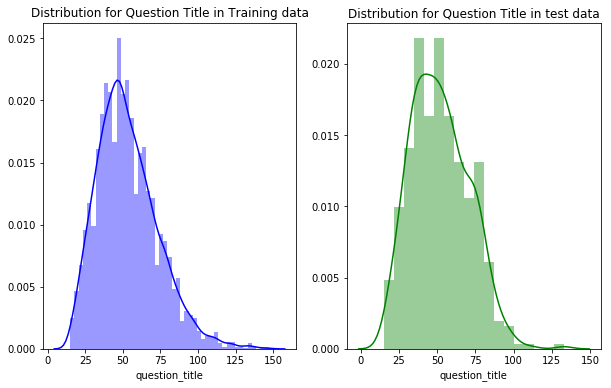

In [ ]:
train_question_title=train_data['question_title'].str.len()
test_question_title=test_data['question_title'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Question Title in test data')
ax1.set_title('Distribution for Question Title in Training data')
plt.show()

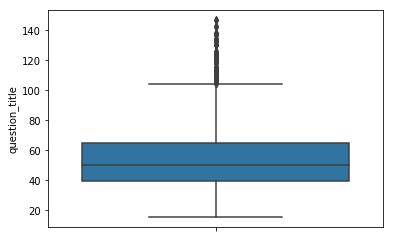

In [ ]:
sns.boxplot(y=train_question_title,data=train_data)
plt.show()

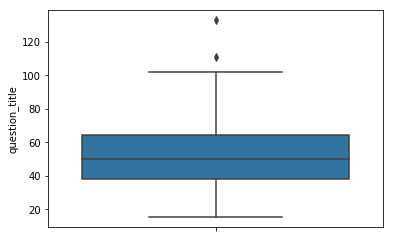

In [ ]:
sns.boxplot(y=test_question_title,data=train_data)
plt.show()

## Distribution for Question Title
- Question title having Number of wods lies between 25 to 50 contribtes more in training as well as testing dataset

## Distribution for Question body¶

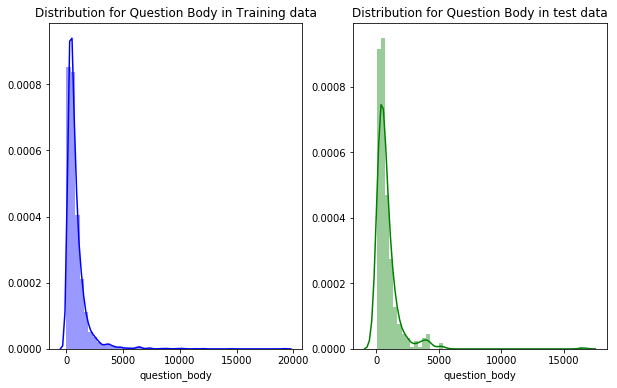

In [ ]:
train_question_title=train_data['question_body'].str.len()
test_question_title=test_data['question_body'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Question Body in test data')
ax1.set_title('Distribution for Question Body in Training data')
plt.show()

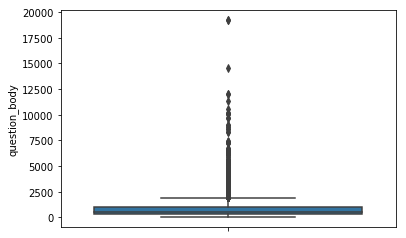

In [ ]:
sns.boxplot(y=train_question_title,data=train_data)
plt.show()

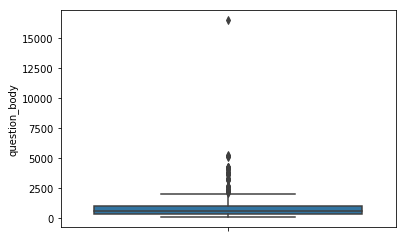

In [ ]:
sns.boxplot(y=test_question_title,data=train_data)
plt.show()

## Distribution for Question 
- Question Body having Number of wods lies between 300 to 500 contribtes more in training as well as testing dataset

## Distribution for Answers


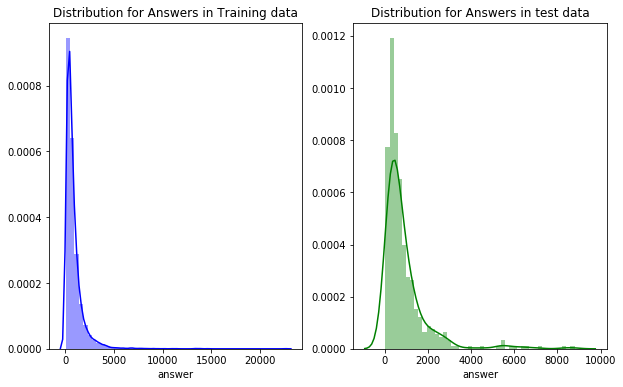

In [ ]:
train_question_title=train_data['answer'].str.len()
test_question_title=test_data['answer'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Answers in test data')
ax1.set_title('Distribution for Answers in Training data')
plt.show()


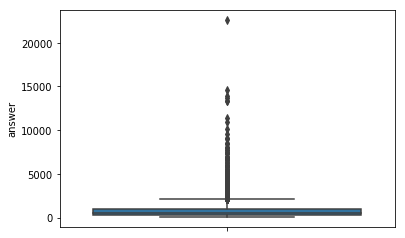

In [ ]:
sns.boxplot(y=train_question_title,data=train_data)
plt.show()

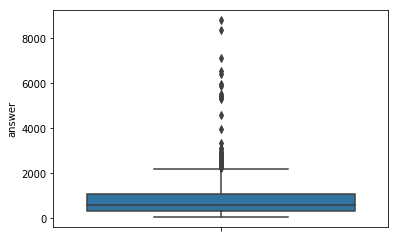

In [ ]:
sns.boxplot(y=test_question_title,data=train_data)
plt.show()

## Distribution for Question answer
- Question Answer having Number of wods lies between 300 to 500 contribtes more in training as well as testing dataset

## Duplicate Questions Title & Most popular Questions

In [ ]:
#  Duplicate Questions
print("Number of duplicate questions in descending order")
print("------------------------------------------------------")
train_data.groupby('question_title').count()['qa_id'].sort_values(ascending=False).head(25)

Number of duplicate questions in descending order
------------------------------------------------------


question_title
What is the best introductory Bayesian statistics textbook?                        12
What does mathematics have to do with programming?                                 11
Important non-technical course for programmers?                                    11
How to prevent the "Too awesome to use" syndrome                                    9
Another instructor is pushing me out of the classroom right after my class ends     7
No sound in Ubuntu except at log in                                                 7
How do I deal with a slow and undedicated colleague in the team?                    7
What are the benefits of owning a physical book?                                    7
House rules to make the cloister less of a game winning tile in Carcassonne?        6
Making sure that you have comprehended a concept                                    6
hide javascript/jquery scripts from html page?                                      6
What is the best place to start Warhamm

## Most popular questions

In [ ]:
train_data[train_data['question_title'] == 'What is the best introductory Bayesian statistics textbook?']

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
229,366,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"""Bayesian Core: A Practical Approach to Comput...",gappy,https://stats.stackexchange.com/users/30,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,0.777778,0.666667,1.000000,1.000000,0.933333,0.0,0.0,0.000000,1.000000
1616,2536,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I am now reading : From Algorithm to Z-Scores:...,Fabio,https://stats.stackexchange.com/users/40316,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,0.555556,0.444444,1.000000,0.888889,0.666667,0.0,0.0,0.000000,0.777778
1647,2591,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"My favorite is ""Bayesian Data Analysis"" by Gel...",Shane,https://stats.stackexchange.com/users/5,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,0.888889,0.888889,0.666667,1.000000,1.000000,1.000000,0.0,0.0,0.000000,1.000000
2104,3349,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I have read some parts of A First Course in Ba...,George Dontas,https://stats.stackexchange.com/users/339,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,0.777778,0.555556,1.000000,1.000000,0.800000,0.0,0.0,0.000000,0.888889
3476,5543,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Sivia and Skilling, Data analysis: a Bayesian ...",denis,https://stats.stackexchange.com/users/557,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.800000,0.0,0.0,0.666667,1.000000
3762,5989,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,If I had to choose a single text for a beginne...,Jim Stone,https://stats.stackexchange.com/users/26779,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.933333,0.0,0.0,1.000000,1.000000
3801,6041,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Take a look at ""The Bayesian Choice"". It has t...",Zen,https://stats.stackexchange.com/users/9394,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,0.0,0.0,0.000000,1.000000
3899,6215,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I found an excellent introduction in Gelman an...,Jack Tanner,https://stats.stackexchange.com/users/8207,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,0.0,0.0,0.333333,1.000000
4408,7003,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,Its focus isn't strictly on Bayesian statistic...,Joe,https://stats.stackexchange.com/users/1119,http://stats.stackexchange.com/questions/125/w...,SCIENCE,...,0.888889,0.777778,0.666667,1.000000,1.000000,1.000000,0.0,0.0,0.000000,1.000000
5239,8328,What is the best introductory Bayesian statist..

In [ ]:
train_data['category'].value_counts().index

Index(['TECHNOLOGY', 'STACKOVERFLOW', 'CULTURE', 'SCIENCE', 'LIFE_ARTS'], dtype='object')

##  ploting some WordClouds by Categories

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in tqdm(train_data[train_data['category'] =='TECHNOLOGY']['answer'].astype(str)):
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████| 2441/2441 [00:53<00:00, 45.88it/s] 


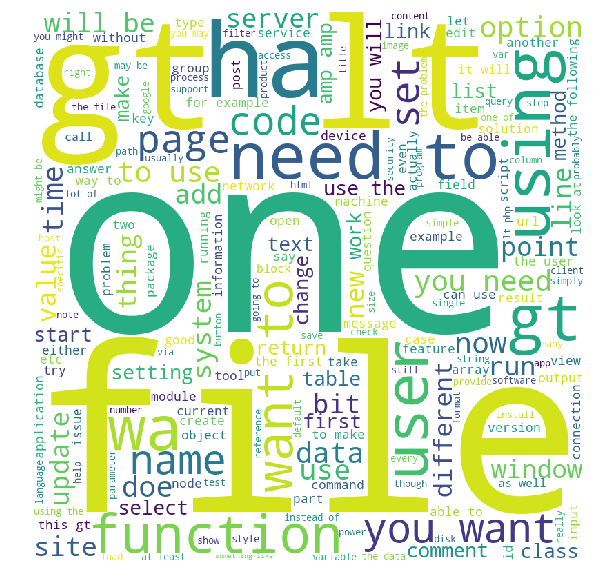

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in tqdm(train_data[train_data['category'] =='STACKOVERFLOW']['answer'].astype(str)):
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████| 1253/1253 [00:06<00:00, 184.03it/s]


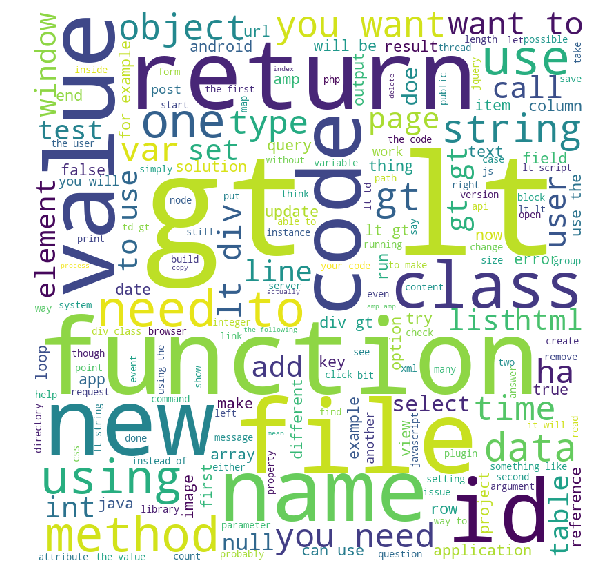

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in tqdm(train_data[train_data['category'] =='CULTURE']['answer'].astype(str)):
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████| 963/963 [00:10<00:00, 91.76it/s]  


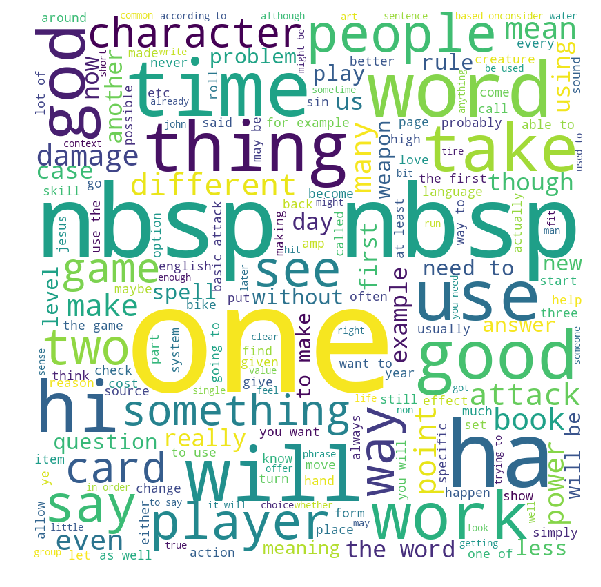

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in tqdm(train_data[train_data['category'] =='SCIENCE']['answer'].astype(str)):
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████| 713/713 [00:06<00:00, 112.85it/s]


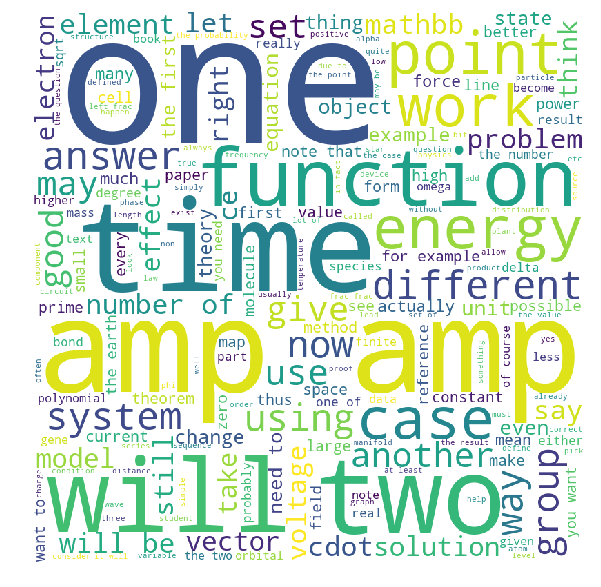

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS) 
for val in tqdm(train_data[train_data['category'] =='LIFE_ARTS']['answer'].astype(str)):
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████| 709/709 [00:06<00:00, 102.98it/s]


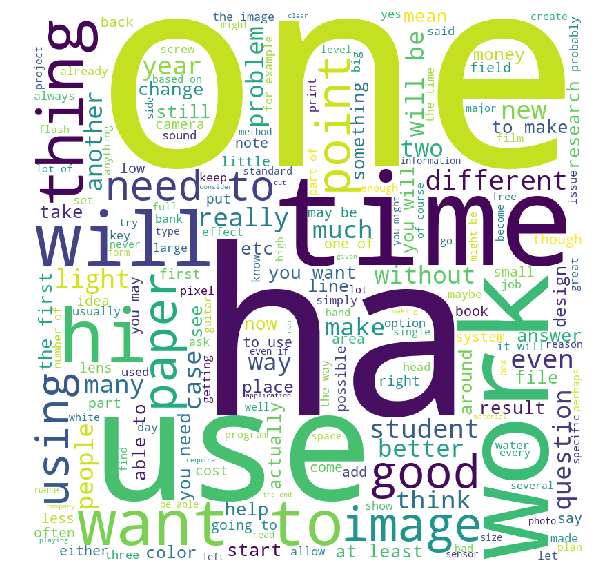

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
# print("Data cleaning started........")
# puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
#  '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
#  '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
#  '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
#  '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
# mispell_dict = {"aren't" : "are not",
# "can't" : "cannot",
# "couldn't" : "could not",
# "couldnt" : "could not",
# "didn't" : "did not",
# "doesn't" : "does not",
# "doesnt" : "does not",
# "don't" : "do not",
# "hadn't" : "had not",
# "hasn't" : "has not",
# "haven't" : "have not",
# "havent" : "have not",
# "he'd" : "he would",
# "he'll" : "he will",
# "he's" : "he is",
# "i'd" : "I would",
# "i'd" : "I had",
# "i'll" : "I will",
# "i'm" : "I am",
# "isn't" : "is not",
# "it's" : "it is",
# "it'll":"it will",
# "i've" : "I have",
# "let's" : "let us",
# "mightn't" : "might not",
# "mustn't" : "must not",
# "shan't" : "shall not",
# "she'd" : "she would",
# "she'll" : "she will",
# "she's" : "she is",
# "shouldn't" : "should not",
# "shouldnt" : "should not",
# "that's" : "that is",
# "thats" : "that is",
# "there's" : "there is",
# "theres" : "there is",
# "they'd" : "they would",
# "they'll" : "they will",
# "they're" : "they are",
# "theyre":  "they are",
# "they've" : "they have",
# "we'd" : "we would",
# "we're" : "we are",
# "weren't" : "were not",
# "we've" : "we have",
# "what'll" : "what will",
# "what're" : "what are",
# "what's" : "what is",
# "what've" : "what have",
# "where's" : "where is",
# "who'd" : "who would",
# "who'll" : "who will",
# "who're" : "who are",
# "who's" : "who is",
# "who've" : "who have",
# "won't" : "will not",
# "wouldn't" : "would not",
# "you'd" : "you would",
# "you'll" : "you will",
# "you're" : "you are",
# "you've" : "you have",
# "'re": " are",
# "wasn't": "was not",
# "we'll":" will",
# "didn't": "did not",
# "tryin'":"trying"}


# def clean_text(text):
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
#     text = text.lower().split()
#     stopwords = set(STOPWORDS) 
# #     stops = set(stopwords.words("english"))
#     text = [w for w in text if not w in stopwords]    
#     text = " ".join(text)
#     return(text)

# def _get_mispell(mispell_dict):
#     mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
#     return mispell_dict, mispell_re

# def replace_typical_misspell(text):
#     mispellings, mispellings_re = _get_mispell(mispell_dict)

#     def replace(match):
#         return mispellings[match.group(0)]

#     return mispellings_re.sub(replace, text)

# def clean_data(df, columns: list):
#     for col in columns:
#         df[col] = df[col].apply(lambda x: clean_text(x.lower()))
#         df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

#     return df

In [ ]:
# columns = ['question_title','question_body','answer']
# train_data = clean_data(train_data, columns)
# test_data = clean_data(test_data, columns)
# print("Data cleaning Done........")

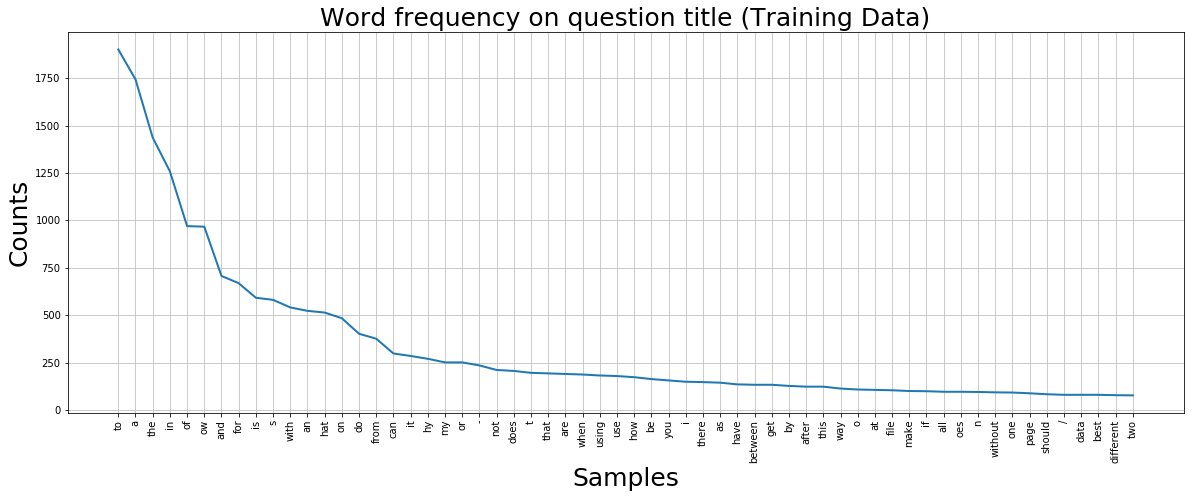

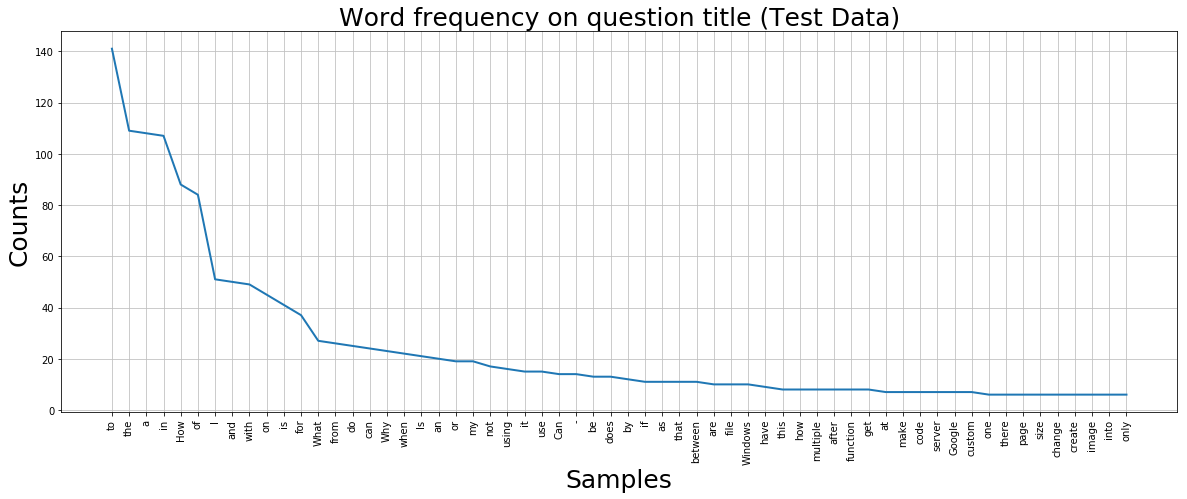

In [ ]:
#  training data
freq_dist = FreqDist([word for text in train_data['question_title'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

## Conclusion
- Word 'using' having maximum Number of Occurence in train as well as test data 
- Use ,-, files word also occur in train as well as in test data with almost same Frequency.
- The First three word in train as well as in test Data is same after word frequecy start changing.

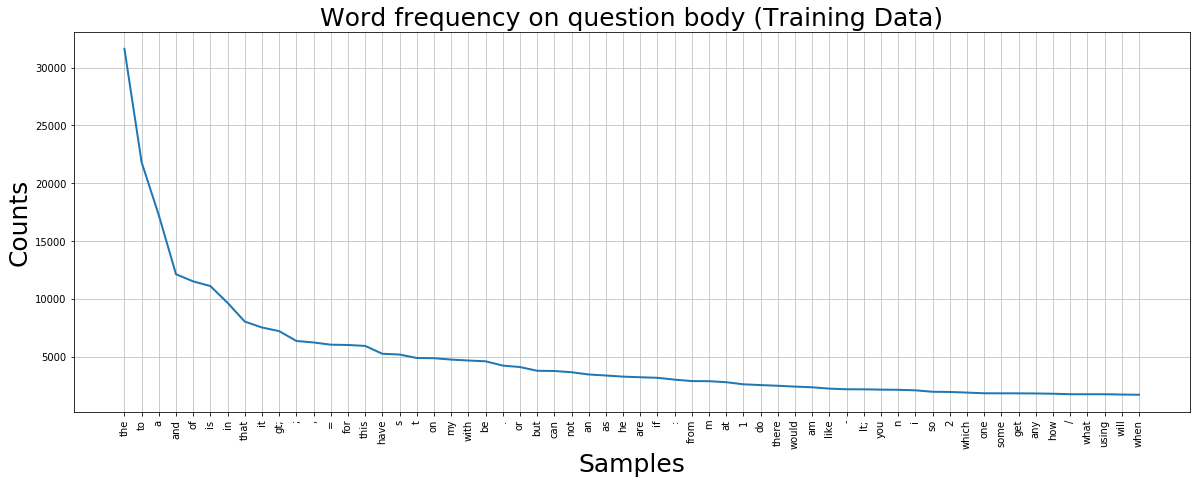

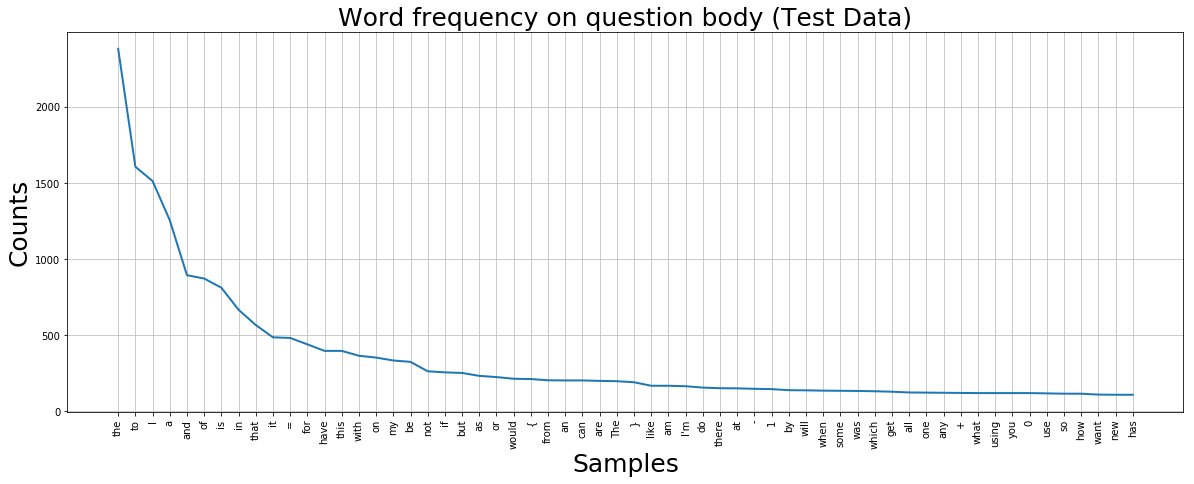

In [ ]:
# training data
freq_dist = FreqDist([word for text in train_data['question_body'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_body'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

## Conclusion
- semicolon  having maximum Number of Occurence in train as well as test data 
- ';' ,'=', '''  also occur in train as well as in test data with almost same Frequency.
- The First three word in train as well as in test Data is same after word frequecy start changing.

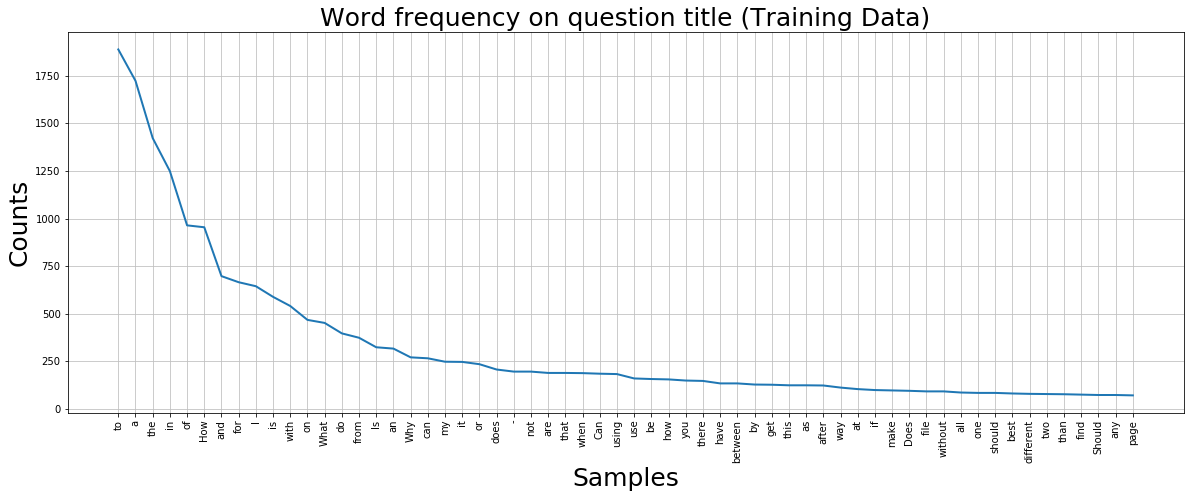

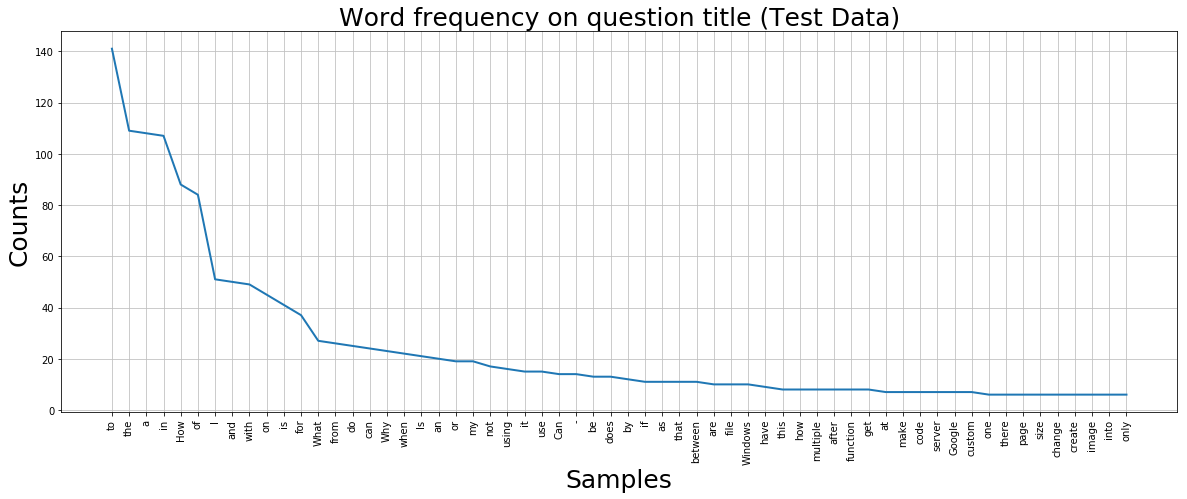

In [ ]:
# training data
freq_dist = FreqDist([word for text in train_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

# test data
freq_dist = FreqDist([word for text in test_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

## Conclusion
- 'using'  having maximum Number of Occurence in train as well as test data 
- 'using' ,'use', '-  also occur in train as well as in test data with almost same Frequency.
- The First three word in train as well as in test Data is same after word frequecy start changing.

<h1> Exploring Target Features</h1>

<h2> Distribution of all Target Features</h2>

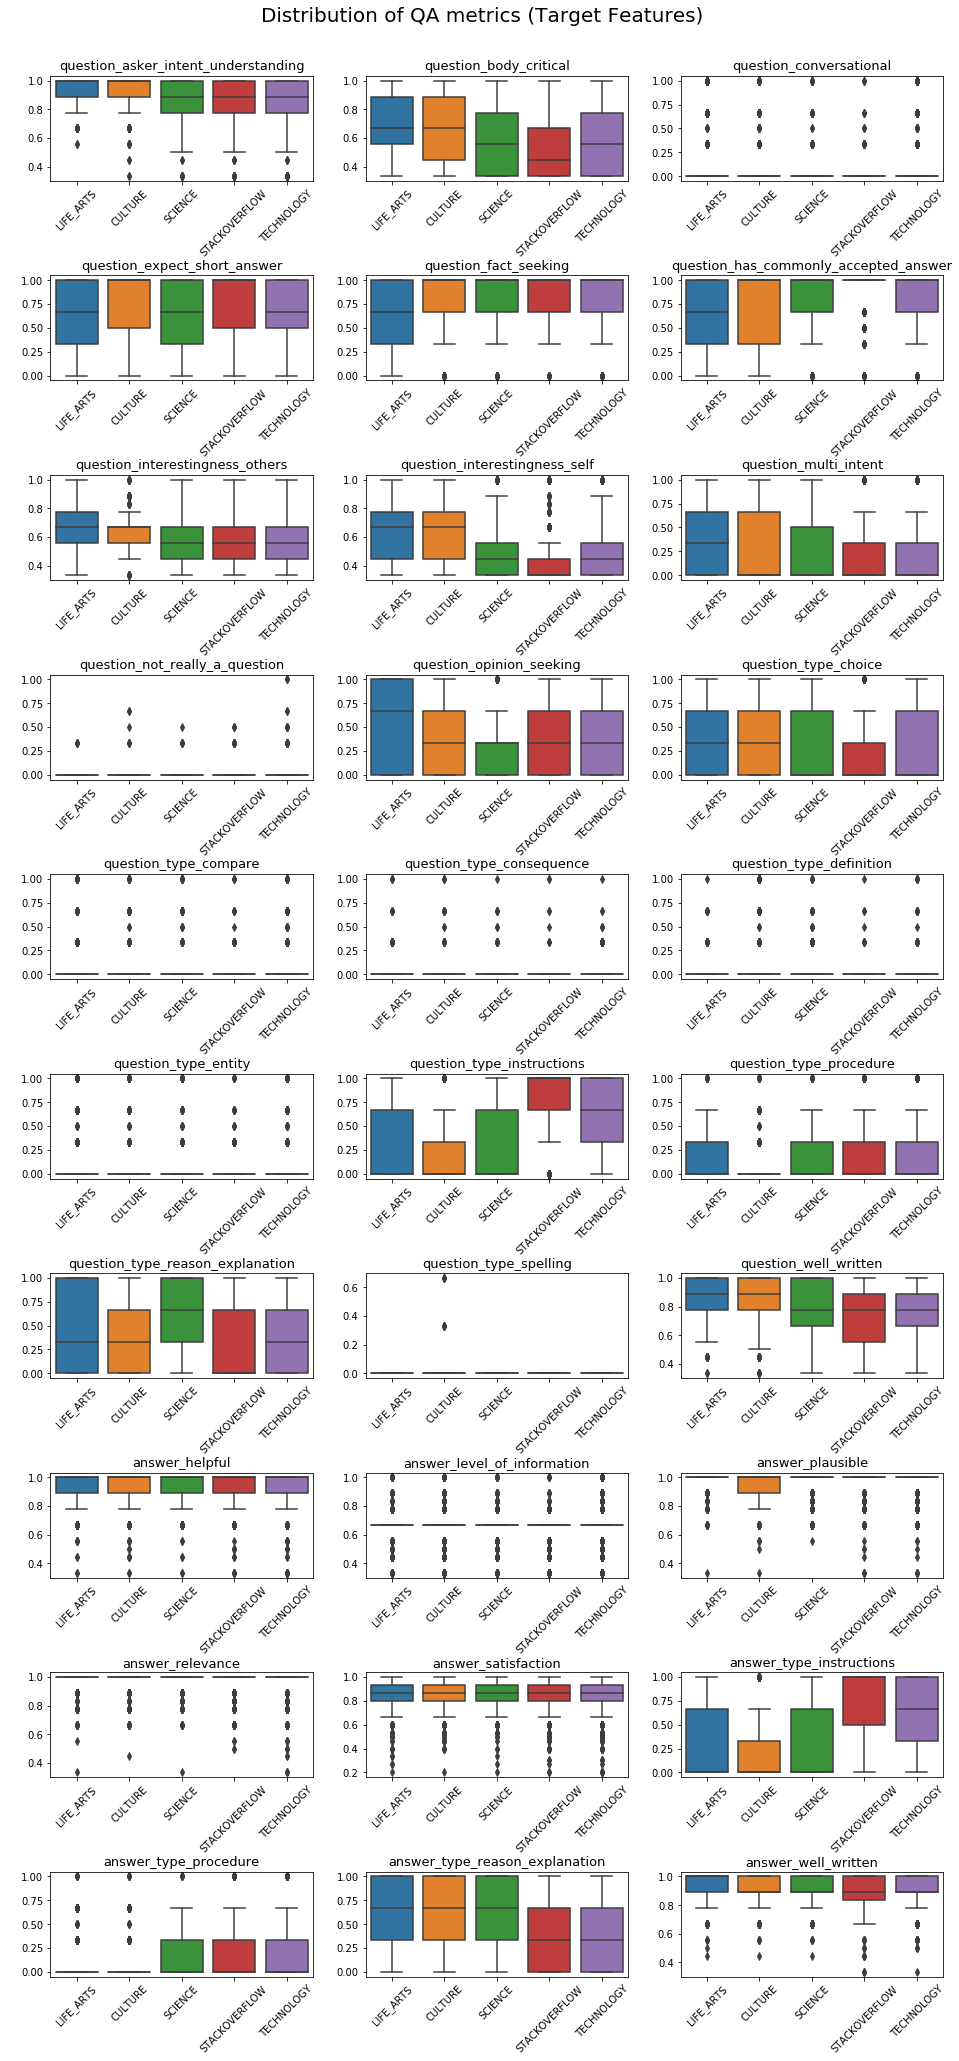

In [ ]:
grid = gridspec.GridSpec(10, 3)
target_columns = list(sample_submission.columns)[1:]

plt.figure(figsize=(16,8*4))
count=0
plt.suptitle('Distribution of QA metrics (Target Features)', size=20)
# top_host = df_train['host_cat'].value_counts()[:15].index
for n, col in enumerate(target_columns):
    ax = plt.subplot(grid[count])
    sns.boxplot(x='category', y=col, data=train_data)
    ax.set_title(str(col), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)

plt.show()

<h2> Conslusion Distribution of all Target Features vs Category </h2>

- The above plot a informative chart where we can get the difference between the categories to each target feature.
- question body critical" has an interesting distribution between the different categories has lot of variation.
- question_asker_intent_understanding doesn't show lot varition vs catrgory all 25-75 percentile is same only.
- From the Box Plot question body critical  show lot of varition against category
- Target Variable question_not_really_question show lot of varition against category.
- Rest all variable does not have very much variance.



In [ ]:
import re
question_related_target_cols = [ col for col in target_columns if re.search('^question_', col)]
answer_related_target_cols = [ col for col in target_columns if re.search('^answer_', col)]

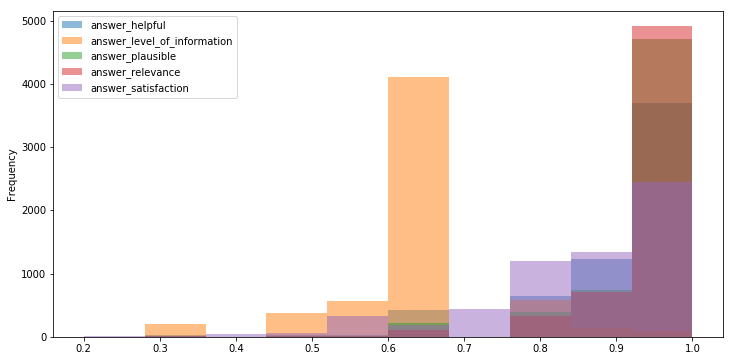

In [ ]:
train_data[answer_related_target_cols[:5]].plot(kind='hist', figsize=(12, 6), alpha=0.5)

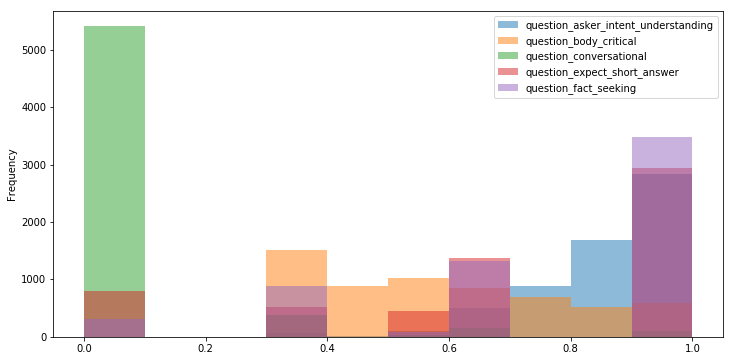

In [ ]:
train_data[question_related_target_cols[:5]].plot(kind='hist', figsize=(12, 6), alpha=0.5)

## Conclusion Frequency vs Question Related Column , Answer Related Column  

- From the above Histogram we can conclude that Frequency answer related target has value grater than 0.5
- From the above Histogram we can conclude that Frequency question related target has value grater of 0 ad second largest is 1.

<h1> Variable Correlations </h1>

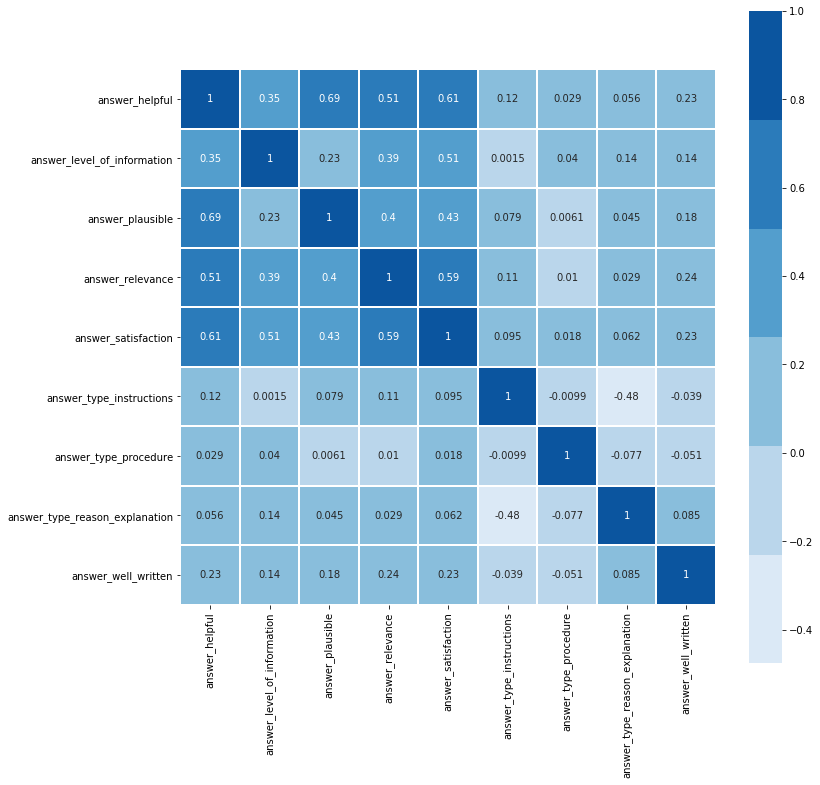

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_data[answer_related_target_cols].corr(), 
            square=True, 
            annot=True,
            linewidths=1, 
            cmap=sns.color_palette("Blues"))

<h2> Conclusion Variable Correlations </h2>



- The above variable correlation heat map answer_related_target_cols describe how answer related the feature related with each other

- As Answer plausable and answer helpfull is very Related with Each other.

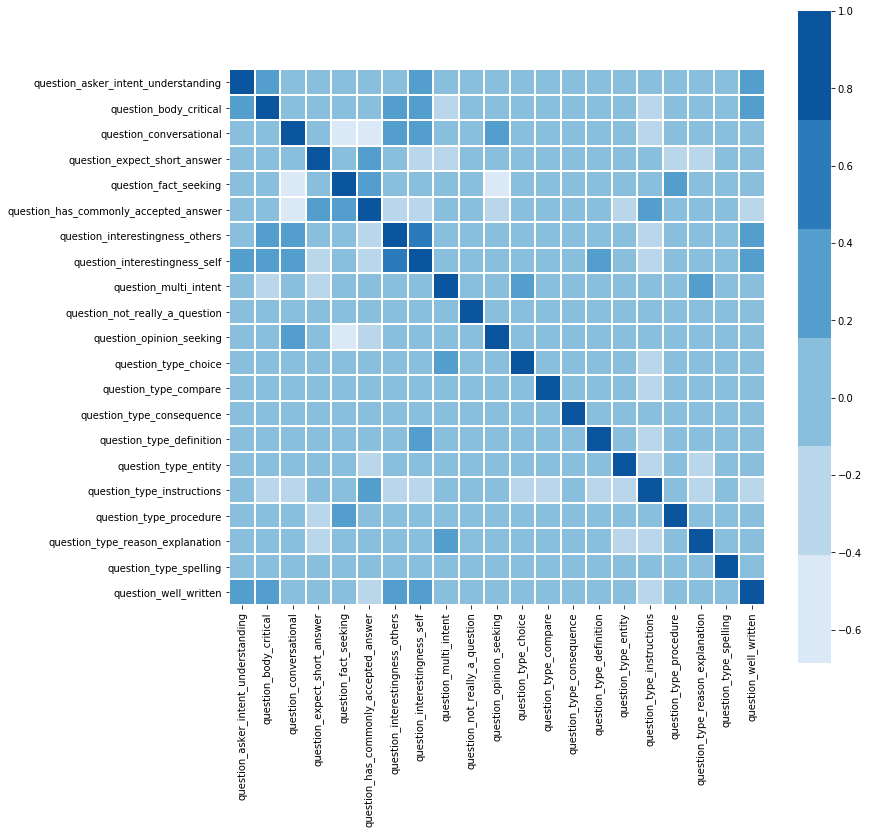

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_data[question_related_target_cols].corr(), 
            square=True, 
            linewidths=1, 
            cmap=sns.color_palette("Blues"))

<h2> Conclusion Variable Correlations </h2>

- The above variable correlation heat map question_related_target_cols describe how question related the feature related with each other

- As question instrestingness self and question instrestingness other is very Related with Each other.


# Feature Engineering

- Number of characters in the question_title
- Number of characters in the question_body
- Number of characters in the answer
- Number of words in the question_title
- Number of words in the question_body
- Number of words in the answer
- Number of unique words in the question_title
- Number of unique words in the question_body
- Number of unique words in the answer

In [ ]:
# Number of characters in the text
train_data["question_title_num_chars"] = train_data["question_title"].apply(lambda x: len(str(x)))
train_data["question_body_num_chars"] = train_data["question_body"].apply(lambda x: len(str(x)))
train_data["answer_num_chars"] = train_data["answer"].apply(lambda x: len(str(x)))

test_data["question_title_num_chars"] = test_data["question_title"].apply(lambda x: len(str(x)))
test_data["question_body_num_chars"] = test_data["question_body"].apply(lambda x: len(str(x)))
test_data["answer_num_chars"] = test_data["answer"].apply(lambda x: len(str(x)))

# Number of words in the text
train_data["question_title_num_words"] = train_data["question_title"].apply(lambda x: len(str(x).split()))
train_data["question_body_num_words"] = train_data["question_body"].apply(lambda x: len(str(x).split()))
train_data["answer_num_words"] = train_data["answer"].apply(lambda x: len(str(x).split()))

test_data["question_title_num_words"] = test_data["question_title"].apply(lambda x: len(str(x).split()))
test_data["question_body_num_words"] = test_data["question_body"].apply(lambda x: len(str(x).split()))
test_data["answer_num_words"] = test_data["answer"].apply(lambda x: len(str(x).split()))

# Number of unique words in the text
train_data["question_title_num_unique_words"] = train_data["question_title"].apply(lambda x: len(set(str(x).split())))
train_data["question_body_num_unique_words"] = train_data["question_body"].apply(lambda x: len(set(str(x).split())))
train_data["answer_num_unique_words"] = train_data["answer"].apply(lambda x: len(set(str(x).split())))

test_data["question_title_num_unique_words"] = test_data["question_title"].apply(lambda x: len(set(str(x).split())))
test_data["question_body_num_unique_words"] = test_data["question_body"].apply(lambda x: len(set(str(x).split())))
test_data["answer_num_unique_words"] = test_data["answer"].apply(lambda x: len(set(str(x).split())))

<h1> Data Preprocessing </h2>

<h2> Data Preprocessing question_title </h2>

In [ ]:
target_columns = list(sample_submission.columns)[1:]

In [ ]:
print(len(target_columns))
print(target_columns)

30
['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [ ]:
final_dataset = train_data.drop(target_columns, axis=1)
final_dataset_target = train_data[target_columns].copy()

In [ ]:
print(final_dataset.shape)
print(final_dataset_target.shape)

(6079, 20)
(6079, 30)


In [ ]:
final_dataset.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_title_num_chars',
       'question_body_num_chars', 'answer_num_chars',
       'question_title_num_words', 'question_body_num_words',
       'answer_num_words', 'question_title_num_unique_words',
       'question_body_num_unique_words', 'answer_num_unique_words'],
      dtype='object')

In [ ]:
# printing some random reviews comment Title
print(final_dataset['question_title'].values[0])
print("="*50)
print(final_dataset['question_title'].values[50])
print("="*50)
print(final_dataset['question_title'].values[100])
print("="*50)
print(final_dataset['question_title'].values[1000])
print("="*50)
print(final_dataset['question_title'].values[5000])
print("="*50)

What am I losing when using extension tubes instead of a macro lens?
AES using derived keys / IVs. Does it introduce a weakness?
Where exactly is the London Shoreditch National Express Coach Stop?
Using a Wiener Filter to Estimate a Transfer Function
Do I need Android SDK to connect my phone in USB debug mode?


In [ ]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character  
from tqdm import tqdm
preprocessed_question_title= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['question_title'].values):
    sentance = sentance.replace('\r', ' ')
    sentance = sentance.replace('\\"', ' ')
    sentance = sentance.replace('\n', ' ')
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = re.sub(r'[^\w]', ' ', sentance)
    sentance = re.sub(r"\s+", " ", sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    preprocessed_question_title.append(sentance.lower().strip())
final_dataset['preprocessed_question_title'] = preprocessed_question_title
final_dataset.drop(['question_title'], axis=1, inplace=True)

100%|██████████| 6079/6079 [00:00<00:00, 58175.27it/s]


In [ ]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_question_title'].values[0])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[50])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[100])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[1000])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[5000])
print("="*50)

what am i losing when using extension tubes instead of a macro lens
aes using derived keys ivs does it introduce a weakness
where exactly is the london shoreditch national express coach stop
using a wiener filter to estimate a transfer function
do i need android sdk to connect my phone in usb debug mode


<h2> Data Preprocessing question_body </h2>

In [ ]:
# printing some random reviews comment Title
print(final_dataset['question_body'].values[0])
print("="*50)
print(final_dataset['question_body'].values[50])
print("="*50)
print(final_dataset['question_body'].values[100])
print("="*50)
print(final_dataset['question_body'].values[1000])
print("="*50)
print(final_dataset['question_body'].values[5000])
print("="*50)

After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.

So, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens. An alternative is the electrical extension tubes.

Except for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2.8) instead of a macro lens?

I'm looking for an efficient way to encrypt multiple fields in a database with AES using a single global key, used throughout a large web application.

Obviously i

In [ ]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character  
from tqdm import tqdm
preprocessed_question_body= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['question_body'].values):
    sentance = sentance.replace('\r', ' ')
    sentance = sentance.replace('\\"', ' ')
    sentance = sentance.replace('\n', ' ')
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = re.sub(r'[^\w]', ' ', sentance)
    sentance = re.sub(r"\s+", " ", sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    preprocessed_question_body.append(sentance.lower().strip())
final_dataset['preprocessed_question_body'] = preprocessed_question_body
final_dataset.drop(['question_body'], axis=1, inplace=True)

100%|██████████| 6079/6079 [00:01<00:00, 6039.67it/s]


In [ ]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_question_body'].values[0])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[50])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[100])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[1000])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[5000])
print("="*50)

after playing around with macro photography on the cheap read reversed lens rev lens mounted on a straight lens passive extension tubes i would like to get further with this the problems with the techniques i used is that focus is manual and aperture control is problematic at best this limited my setup to still subjects read dead insects now as spring is approaching i want to be able to shoot live insects i believe that for this autofocus and settable aperture will be of great help so one obvious but expensive option is a macro lens say ef 100mm macro however i am not really interested in yet another prime lens an alternative is the electrical extension tubes except for maximum focusing distance what am i losing when using tubes coupled with a fine lens say ef70 200 2 8 instead of a macro lens
i m looking for an efficient way to encrypt multiple fields in a database with aes using a single global key used throughout a large web application obviously in order to re use this key a unique

<h2> Data Preprocessing question_answer </h2>

In [ ]:
# printing some random reviews comment Title
print(final_dataset['answer'].values[0])
print("="*50)
print(final_dataset['answer'].values[50])
print("="*50)
print(final_dataset['answer'].values[100])
print("="*50)
print(final_dataset['answer'].values[1000])
print("="*50)
print(final_dataset['answer'].values[5000])
print("="*50)

I just got extension tubes, so here's the skinny.


  ...what am I losing when using tubes...?


A very considerable amount of light!  Increasing that distance from the end of the lens to the sensor can cut your light several stops.  Combined with the fact that you'll usually shoot stopped down - expect to need to increase your ISO considerably.

The fact the macro's are usually considered very very sharp, although I believe that 70-200mm 2.8 is supposed to be quite sharp.

The ultra low distortion typical of many macros.

I wouldn't worry too much about the bokeh since the DOF will still be quite limited.

Coupled on my 50mm, a full 60mm'ish extension tube results in a DOF of about a couple inches in front of the lens.  On my 70-300, its probably around 2-3 feet in front of the lens to about a foot in front of the lens.

A potentially better approach would be to store the IV and ciphertext in one column. This way, you can generate IVs in the way most appropriate for your choice of enc

In [ ]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character  
from tqdm import tqdm
preprocessed_answer_body= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['answer'].values):
    sentance = sentance.replace('\r', ' ')
    sentance = sentance.replace('\\"', ' ')
    sentance = sentance.replace('\n', ' ')
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = re.sub(r'[^\w]', ' ', sentance)
    sentance = re.sub(r"\s+", " ", sentance)
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    preprocessed_answer_body.append(sentance.lower().strip())
final_dataset['preprocessed_answer_body'] = preprocessed_answer_body
final_dataset.drop(['answer'], axis=1, inplace=True)

100%|██████████| 6079/6079 [00:01<00:00, 6020.05it/s]


In [ ]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_answer_body'].values[0])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[50])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[100])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[1000])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[5000])
print("="*50)

i just got extension tubes so here s the skinny what am i losing when using tubes a very considerable amount of light increasing that distance from the end of the lens to the sensor can cut your light several stops combined with the fact that you ll usually shoot stopped down expect to need to increase your iso considerably the fact the macro s are usually considered very very sharp although i believe that 70 200mm 2 8 is supposed to be quite sharp the ultra low distortion typical of many macros i wouldn t worry too much about the bokeh since the dof will still be quite limited coupled on my 50mm a full 60mm ish extension tube results in a dof of about a couple inches in front of the lens on my 70 300 its probably around 2 3 feet in front of the lens to about a foot in front of the lens
a potentially better approach would be to store the iv and ciphertext in one column this way you can generate ivs in the way most appropriate for your choice of encryption mode while also not having to 

<h2> Data Preprocessing question </h2>

<h1> Detailed Conclusion Exploratory Data Analysis and Feature Engineering </h1>

<h2> Conclusion Distribution of Host(from which website Question & Answers collected) </h2>

In Training DataSet Stackoverflow.com from which most website Question & Answers collected over 20.6% and 1253 datapoint.
english.stackexchange.com has contributed 3.77 % and 229 in DataSet.
In Testing DataSet Stackoverflow.com from which most website Question & Answers collected over 21.6% and 103 datapoint.
english.stackexchange.com has contributed 4.2 % and 20 in DataSet.

<h2> Conclusion Distribution of categories in training data in % and Testting Data </h2>


Distribution of Categories is a Categorical Data conatin Technology,StackoverFlow,Culture , Science and Life arts
Technology and Stackoverflow has contributed Maximum in training as well as Testing Data set
Technology = 40% in Training data set and 42.85 % in testing Data set.

<h2>Conclusion Common Features values in training and test data </h2>

Above Ven diagram shows that common feature in training and testing Data set
There no common question_title present in traning and testing dataset.i.e all question title is unique in testing dataset.
The Most common Feature present in training as well as testing is answer_user_name is 405


<h2> Distribution for Question Title </h2>

Question title having Number of wods lies between 25 to 50 contribtes more in training as well as testing dataset


<h2> Distribution for Question </h2>

Question Body having Number of wods lies between 300 to 500 contribtes more in training as well as testing dataset

<h2> Distribution for Question answer </h2>

Question Answer having Number of words lies between 300 to 500 contribtes more in training as well as testing dataset

<h2> Conclusion Question </h2>

Word 'using' having maximum Number of Occurence in train as well as test data
Use ,-, files word also occur in train as well as in test data with almost same Frequency.
The First three word in train as well as in test Data is same after word frequecy start changing.

<h2> Conclusion Title </h2>

semicolon having maximum Number of Occurence in train as well as test data
';' ,'=', ''' also occur in train as well as in test data with almost same Frequency.
The First three word in train as well as in test Data is same after word frequecy start changing.

<h2> Conclusion Answer </h2>

'using' having maximum Number of Occurence in train as well as test data
'using' ,'use', '- also occur in train as well as in test data with almost same Frequency.
The First three word in train as well as in test Data is same after word frequecy start changing.

<h2> Conslusion Distribution of all Target Features vs Category </h2>

- The above plot a informative chart where we can get the difference between the categories to each target feature.
- question body critical" has an interesting distribution between the different categories has lot of variation.
- question_asker_intent_understanding doesn't show lot varition vs catrgory all 25-75 percentile is same only.
- From the Box Plot question body critical  show lot of varition against category
- Target Variable question_not_really_question show lot of varition against category.
- Rest all variable does not have very much variance.



## Conclusion Frequency vs Question Related Column , Answer Related Column  

- From the above Histogram we can conclude that Frequency answer related target has value grater than 0.5
- From the above Histogram we can conclude that Frequency question related target has value grater of 0 ad second largest is 1.

<h2> Conclusion Variable Correlations Question</h2>



- The above variable correlation heat map answer_related_target_cols describe how answer related the feature related with each other

- As Answer plausable and answer helpfull is very Related with Each other.

<h2> Conclusion Variable Correlations Question</h2>

- The above variable correlation heat map question_related_target_cols describe how question related the feature related with each other

- As question instrestingness self and question instrestingness other is very Related with Each other.


# Feature Engineering
- Number of characters in the question_title
- Number of characters in the question_body
- Number of characters in the answer
- Number of words in the question_title
- Number of words in the question_body
- Number of words in the answer
- Number of unique words in the question_title
- Number of unique words in the question_body
- Number of unique words in the answer

In [ ]:
# tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


<h1> Deep Learning LSTM </h1>

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import LSTM,Bidirectional
import keras
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Reshape,Concatenate
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.core import Dense, Dropout
import tensorflow_hub as hub
from absl import logging

Using TensorFlow backend.


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
from keras.layers import Input, Lambda, Dense
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(['Hello Deelip'])

In [ ]:
final_dataset.columns

Index(['qa_id', 'question_user_name', 'question_user_page', 'answer_user_name',
       'answer_user_page', 'url', 'category', 'host',
       'question_title_num_chars', 'question_body_num_chars',
       'answer_num_chars', 'question_title_num_words',
       'question_body_num_words', 'answer_num_words',
       'question_title_num_unique_words', 'question_body_num_unique_words',
       'answer_num_unique_words', 'preprocessed_question_title',
       'preprocessed_question_body', 'preprocessed_answer_body'],
      dtype='object')

In [ ]:
print(final_dataset.shape)
print("=="*62)
from sklearn.model_selection import train_test_split
project_data_train, project_data_cv, result_data_train, result_data_cv = train_test_split(final_dataset,final_dataset_target, test_size=0.10)
print(project_data_train.shape,project_data_cv.shape)
print(result_data_train.shape,result_data_cv.shape)

(6079, 20)
(5471, 20) (608, 20)
(5471, 30) (608, 30)


<h1> One Hot Encoding of Categorical Feature 

In [ ]:
# Make Data Model ready- Encoding category
print("Before vectorizations")

print(project_data_train.shape, result_data_train.shape)
print(project_data_cv.shape, result_data_cv.shape)
vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# 
X_train_category = vectorizer.transform(project_data_train['category'].values)
X_cv_category =  vectorizer.transform(project_data_cv['category'].values)

print("After vectorizations")
print(X_train_category.shape, result_data_train.shape)
print(X_cv_category.shape, result_data_cv.shape)
print(vectorizer.get_feature_names())
print("="*100)

Before vectorizations
(5471, 20) (5471, 30)
(608, 20) (608, 30)
After vectorizations
(5471, 5) (5471, 30)
(608, 5) (608, 30)
['culture', 'life_arts', 'science', 'stackoverflow', 'technology']


In [ ]:
# Make Data Model ready- Encoding category
print("Before vectorizations")

print(project_data_train.shape, result_data_train.shape)
print(project_data_cv.shape, result_data_cv.shape)
vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['host'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# 
X_train_host = vectorizer.transform(project_data_train['host'].values)
X_cv_host =  vectorizer.transform(project_data_cv['host'].values)

print("After vectorizations")
print(X_train_host.shape, result_data_train.shape)
print(X_cv_host.shape, result_data_cv.shape)
print(vectorizer.get_feature_names())
print("="*100)

Before vectorizations
(5471, 20) (5471, 30)
(608, 20) (608, 30)
After vectorizations
(5471, 62) (5471, 30)
(608, 62) (608, 30)
['academia', 'android', 'anime', 'apple', 'askubuntu', 'bicycles', 'biology', 'blender', 'boardgames', 'chemistry', 'christianity', 'codereview', 'com', 'cooking', 'crypto', 'cs', 'dba', 'diy', 'drupal', 'dsp', 'electronics', 'ell', 'english', 'expressionengine', 'gamedev', 'gaming', 'gis', 'graphicdesign', 'judaism', 'magento', 'math', 'mathematica', 'mathoverflow', 'mechanics', 'meta', 'money', 'movies', 'music', 'net', 'photo', 'physics', 'programmers', 'raspberrypi', 'robotics', 'rpg', 'salesforce', 'scifi', 'security', 'serverfault', 'sharepoint', 'softwarerecs', 'stackexchange', 'stackoverflow', 'stats', 'superuser', 'tex', 'travel', 'unix', 'ux', 'webapps', 'webmasters', 'wordpress']


In [ ]:
# Make Data Model ready- Encoding Customer city

vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['category'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])
category =  vectorizer.get_feature_names()
print("=="*62)
print(len(category))
category_input = Input(shape =(len(category),), name='category',)
category_emb = Embedding(len(category), 2, input_length=len(category))(category_input)
category_flat = Flatten()(category_emb) 

['culture', 'life_arts', 'science', 'stackoverflow', 'technology']
5


In [ ]:
# Make Data Model ready- Encoding Customer city

vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['host'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])
host =  vectorizer.get_feature_names()
print("=="*62)
print(len(host))
host_input = Input(shape =(len(host),), name='host',)
host_emb = Embedding(len(host), 2, input_length=len(host))(host_input)
host_flat = Flatten()(host_emb) 

['academia', 'android', 'anime', 'apple', 'askubuntu', 'bicycles', 'biology', 'blender', 'boardgames', 'chemistry', 'christianity', 'codereview', 'com', 'cooking', 'crypto', 'cs', 'dba', 'diy', 'drupal', 'dsp']
62


## Numerical Field

In [ ]:
num_field_train = np.concatenate((project_data_train['question_title_num_chars'].values.reshape(-1,1),project_data_train['question_body_num_chars'].values.reshape(-1,1),project_data_train['answer_num_chars'].values.reshape(-1,1),project_data_train['question_title_num_words'].values.reshape(-1,1),project_data_train['question_body_num_words'].values.reshape(-1,1),project_data_train['answer_num_words'].values.reshape(-1,1),project_data_train['question_title_num_unique_words'].values.reshape(-1,1),project_data_train['question_body_num_unique_words'].values.reshape(-1,1),project_data_train['answer_num_unique_words'].values.reshape(-1,1)), axis=1)
num_field_cv = np.concatenate((project_data_cv['question_title_num_chars'].values.reshape(-1,1),project_data_cv['question_body_num_chars'].values.reshape(-1,1),project_data_cv['answer_num_chars'].values.reshape(-1,1),project_data_cv['question_title_num_words'].values.reshape(-1,1),project_data_cv['question_body_num_words'].values.reshape(-1,1),project_data_cv['answer_num_words'].values.reshape(-1,1),project_data_cv['question_title_num_unique_words'].values.reshape(-1,1),project_data_cv['question_body_num_unique_words'].values.reshape(-1,1),project_data_cv['answer_num_unique_words'].values.reshape(-1,1)), axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
num_field_train_scalar = scalar.fit_transform(num_field_train)
num_field_cv_scalar = scalar.transform(num_field_cv)

In [ ]:
num_field_input =  Input(shape=(9,), name="num_field_layer")
num_field_dense = Dense(64, activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(num_field_input)
num_field_dense = Dropout(0.4)(num_field_dense)

In [ ]:
# https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-vis-bert/data
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

In [ ]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [ ]:

embed_size = 512 #must be 512 for univerasl embedding layer

input_text1 = Input(shape=(1,), dtype=tf.string)
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string)
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)
input_text3 = Input(shape=(1,), dtype=tf.string)
embedding3 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text3)


In [ ]:
embedding3.shape

TensorShape([None, 512])

In [ ]:
input_columns = ['preprocessed_question_title','preprocessed_question_body','preprocessed_answer_body']

In [ ]:
X1 = project_data_train[input_columns[0]].values
X2 = project_data_train[input_columns[1]].values
X3 = project_data_train[input_columns[2]].values

X_train = [X1,X2,X3]


X_train = [X1,X2,X3,X_train_category,X_train_host,num_field_train_scalar]

In [ ]:
CV1 = project_data_cv[input_columns[0]].values
CV2 = project_data_cv[input_columns[1]].values
CV3 = project_data_cv[input_columns[2]].values

x_cv = [CV1,CV2,CV3,X_cv_category,X_cv_host,num_field_cv_scalar]

In [ ]:
y_train =  result_data_train.values
y_cv =  result_data_cv.values

In [ ]:
concat_layers = []
concat_layers.append(embedding1)
concat_layers.append(embedding2)
concat_layers.append(embedding3)
concat_layers.append(category_flat)
concat_layers.append(host_flat)
concat_layers.append(num_field_dense)

In [ ]:
concat_layers = Concatenate()(concat_layers)

In [ ]:
concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)
concat_layers= Dropout(0.4)(concat_layers)

# concat_layers= Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)
# concat_layers= Dropout(0.4)(concat_layers)

concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)

concat_layers= Dropout(0.4)(concat_layers)
concat_layers = BatchNormalization()(concat_layers)


output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
model_1 = Model(inputs=[input_text1,input_text2,input_text3,category_input,host_input,num_field_input], outputs=output)

In [ ]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
host (InputLayer)               (None, 62)           0                                            
__________________________________________________________________________________________________
num_field_layer (InputLayer)    (None, 9)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse', 'mae'])

In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs=60,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/60
5471/5471 [==============================] - 16s 3ms/step - loss: 1.8465 - mse: 0.2033 - mae: 0.3927 - val_loss: 1.4888 - val_mse: 0.1666 - val_mae: 0.3735
Epoch 2/60
5471/5471 [==============================] - 12s 2ms/step - loss: 1.3886 - mse: 0.1834 - mae: 0.3787 - val_loss: 1.1694 - val_mse: 0.1607 - val_mae: 0.3669
Epoch 3/60
5471/5471 [==============================] - 13s 2ms/step - loss: 1.1250 - mse: 0.1729 - mae: 0.3707 - val_loss: 0.9911 - val_mse: 0.1543 - val_mae: 0.3595
Epoch 4/60
5471/5471 [==============================] - 13s 2ms/step - loss: 0.9778 - mse: 0.1634 - mae: 0.3611 - val_loss: 0.8882 - val_mse: 0.1459 - val_mae: 0.3494
Epoch 5/60
5471/5471 [==============================] - 13s 2ms/step - loss: 0.8870 - mse: 0.1521 - mae: 0.3482 - val_loss: 0.8175 - val_mse: 0.1343 - val_mae: 0.3346
Epoch 6/60
5471/5471 [==============================] - 13s 2ms/step - loss: 0.8184 - mse: 0.1377 - mae: 0.3302 - val_

In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs=1,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/1
5471/5471 [==============================] - 13s 2ms/step - loss: 0.3891 - mse: 0.0391 - mae: 0.1301 - val_loss: 0.4087 - val_mse: 0.0456 - val_mae: 0.1421


In [ ]:
history_1 = model_1.fit(X_train,y_train,epochs=1,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/1
5471/5471 [==============================] - 12s 2ms/step - loss: 0.3882 - mse: 0.0391 - mae: 0.1301 - val_loss: 0.4086 - val_mse: 0.0455 - val_mae: 0.1428


In [ ]:
valid_preds = []
valid_preds.append(model_1.predict(x_cv))

In [ ]:
spear_val = compute_spearmanr_ignore_nan(y_cv, valid_preds[-1])
print('validation score = ', spear_val)

validation score =  0.349053745237342


In [ ]:
<h1> Fastext Word Vector and LSTM </h1>

In [ ]:
import fasttext.util

In [ ]:
! wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,sv;q=0.8" --header="Referer: https://fasttext.cc/docs/en/crawl-vectors.html" --header="Cookie: __cfduid=dd36a09e99a0727afb328a6e33d6b6ed91590356856" --header="Connection: keep-alive" "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz" -c -O 'cc.en.300.vec.gz'

--2020-06-18 20:24:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
import gzip

<h2> Tokenizing the Question title</h2>

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_title'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(project_data_train['preprocessed_question_title'])
print(encoded_docs)
# pad documents to a max length of 600 words
max_length = 600
padded_docs_train_question_title = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# load the whole embedding into memory

[[146, 3193, 3194], [24, 167, 1682, 105, 17, 3780, 3781, 280, 130, 2719, 18, 28, 576, 58, 638, 22, 325, 399, 921], [237, 6, 6777, 520], [176, 1869, 23, 385, 5, 13, 143, 298, 37, 308, 1524, 176, 721, 1116], [5728, 397, 696, 386, 13, 30, 32, 2855, 1, 2, 201, 800, 4, 3, 3746], [11, 25, 3, 6001, 6, 2, 2004, 1975, 1872], [67, 576, 183, 2217, 164, 187, 576, 183], [554, 13, 30, 57, 5766, 4155, 767, 1115, 554, 5767], [1384, 913, 1, 756, 1630], [1425, 3, 4119, 10, 2, 2494], [19, 25, 35, 5069, 14, 21, 5070], [11, 7, 3, 4407, 6, 2, 5962, 4172, 491], [5333, 208, 1, 5334, 47, 40, 1613, 4, 26, 113, 342, 162], [126, 1, 1446, 2012, 105, 53, 2238, 861, 12, 4405, 2162, 4406], [5, 1, 246, 116, 54, 14, 151, 8, 2071], [794, 949, 2141, 4, 42, 522, 27, 1416], [479, 587, 7, 6204, 10, 105, 2, 6205, 24, 6206, 72, 7, 42, 934], [5, 1, 246, 116, 54, 14, 151, 8, 2071], [59, 281, 1, 750, 434, 1729, 83, 43], [916, 2789, 16, 2, 186, 4, 562], [5, 1, 869, 2609, 6591, 634, 6592], [1420, 14, 26, 275, 706, 254], [2718, 111

In [ ]:
print(padded_docs_train_question_title[1])
print(type(padded_docs_train_question_title[1]))
print(len(padded_docs_train_question_title[1]))

[  24  167 1682  105   17 3780 3781  280  130 2719   18   28  576   58
  638   22  325  399  921    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
encoded_docs = t.texts_to_sequences(project_data_cv['preprocessed_question_title'])
padded_docs_cv_question_title = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_cv_question_title[1])
print(type(padded_docs_cv_question_title[1]))
print(len(padded_docs_cv_question_title[1]))

[2597 1374 1174   97  262 3531    8  115   12 3532  310    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<h2> Tokenizing the Question Body</h2>

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_body'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(project_data_train['preprocessed_question_body'])
print(encoded_docs)
# pad documents to a max length of 600 words
max_length = 600
padded_docs_train_question_body = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# load the whole embedding into memory

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(padded_docs_train_question_body[1])
print(type(padded_docs_train_question_body[1]))
print(len(padded_docs_train_question_body[1]))

[    2    16    34   455  2380  1266    49 13785    98  8730  3684    48
  1005    69    33     9   777    32  1608 13786     2   162    82    11
   108    12     4  1692    98    52   173    17   204    27     4  3462
    98    52   248    17  1266    45    61  2020    75     4   496  4777
   204  7020     5    11     1   593   157     7   666     6   762  2129
   736     9 11362    63   223   194  8730   180     2    35    94    36
    30     1   496  1266  5503    23    47    72   131     4  3327  7020
    24    21   458     3    21   496     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
encoded_docs = t.texts_to_sequences(project_data_cv['preprocessed_question_body'])
padded_docs_cv_question_body= pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_cv_question_body[1])
print(type(padded_docs_cv_question_body[1]))
print(len(padded_docs_cv_question_body[1]))

[    2    56  1818    18    15   424     6    16    95    79     4   314
    26  1680  6000  4500    49     5  1505     8    15   361   600    36
   567    55  3280   240    73     5    11     2   392  2105   110     1
   627  6001   292     2    71     1  1267   361     8    15 16727   309
     6    56     9   633     2    16     3  1014     4    59    48   367
   122    24    25     2  2105   110     4   361   164    61   335     8
     1 16728  7762     6   361  7034    16   126  5664  1117   105   356
    14     1  2122    49  5665    79    45  4933     8  1446  2236     6
   759     2    89   596   333     4   188    18   551  2392   131   144
     1  4500   150   477    50   905     2   209    77    39     2    24
 16729     1  2616  2122    63    56  1818   139  1818    65  2361     6
    70     2    24  2105     1  4500   110     1  1143   158     9    82
    26   102    19    15  4500    54  3198  2361   121     8    65  2361
     2    24  7035     1   204   195   637    20   

<h2> Tokenizing the Question answer</h2>

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_answer_body'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(project_data_train['preprocessed_answer_body'])
print(encoded_docs)
# pad documents to a max length of 600 words
max_length = 600
padded_docs_train_question_answer = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# load the whole embedding into memory

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(padded_docs_train_question_answer[1])
print(type(padded_docs_train_question_answer[1]))
print(len(padded_docs_train_question_answer[1]))

[    9     7    23   429     2   106    71     3   159     5   672    52
  5302  9160    13    38  1861     3   457  4812    57   112   457 10625
    74    30     1  1311    96  5416    70   457 10625   239    56    30
     1  1311    96  1061    70   744   672    36   202   292     2 10626
    32  9150   101   134    30  5416     2 21361   872   413   672     1
   159     5   672    70   663   672    36     1   202    70 10625    36
     1   202  7351     1  1311    96   413    70  2108     1  1311    96
  5416   112 10625    74    84  7351     1  1311    96   413   112  2595
    45   793    70  2108    25  2595  4909     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
encoded_docs = t.texts_to_sequences(project_data_cv['preprocessed_answer_body'])
padded_docs_cv_question_answer= pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_cv_question_answer[1])
print(type(padded_docs_cv_question_answer[1]))
print(len(padded_docs_cv_question_answer[1]))

[    1  2534    12  1746  1214    21    15 13285    38   741     1   199
     8     1  1488  1098  1746   130  1746   116  1978    31    43     1
  2498     4    21  2143     1   717    97     1  1098    16 23558   331
   116  1978  1443    66  9757   340     2    15  1844    18  5161 13286
  1746  1214     1   978  2493     7     2  5788     1 23559     6  3479
     9   281    17     1   450  1746  1967   199  3919   236  4466  3483
   116  1978   116  1978  9757  4090  1978     8   116  1978  9757    71
   116  1978   919  6682     2  5788  3875 23560   116  1978  1746 23561
   113   116  1978    88   919  6682     2  3479   281     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_title'])
vocab_size = len(t.word_index) + 1

In [ ]:
file = gzip.open('cc.en.300.vec.gz')

In [ ]:
from tqdm import tqdm
from numpy import asarray
embeddings_index = dict()
for line in tqdm(file):
	values = line.split()
	word = values[0].decode('utf-8')
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
file.close()

2000001it [03:02, 10971.15it/s]


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 7253/7253 [00:00<00:00, 226500.54it/s]


In [ ]:
print(embedding_matrix.shape)

(7254, 300)


In [ ]:
preprocessed_question_title_input = Input(shape=(max_length,), name = "preprocessed_question_title")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_title_input)

lstm= LSTM(128,return_sequences=True)(emb)
dropoutlstm = Dropout(0.2)(lstm)
flat_title= Flatten()(dropoutlstm)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 28007/28007 [00:00<00:00, 259887.95it/s]


In [ ]:
preprocessed_question_body_input = Input(shape=(max_length,), name = "preprocessed_question_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_body_input)

lstm= LSTM(128,return_sequences=True)(emb)
dropoutlstm = Dropout(0.2)(lstm)
flat_question= Flatten()(dropoutlstm)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_answer_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 37594/37594 [00:00<00:00, 269170.12it/s]


In [ ]:
preprocessed_question_answer_input = Input(shape=(max_length,), name = "preprocessed_answer_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_answer_input)
lstm= LSTM(128,return_sequences=True)(emb)
dropoutlstm = Dropout(0.2)(lstm)
flat_answer= Flatten()(dropoutlstm)

In [ ]:
concat_layers = []
concat_layers.append(flat_title)
concat_layers.append(flat_question)
concat_layers.append(flat_answer)
concat_layers.append(category_flat)
concat_layers.append(host_flat)
concat_layers.append(num_field_dense)

In [ ]:
concat_layers = Concatenate()(concat_layers)

In [ ]:
concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)
concat_layers= Dropout(0.4)(concat_layers)

concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)

concat_layers= Dropout(0.4)(concat_layers)
concat_layers = BatchNormalization()(concat_layers)


output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
model_2 = Model(inputs=[preprocessed_question_title_input,preprocessed_question_body_input,preprocessed_question_answer_input,category_input,host_input,num_field_input], outputs=output)

In [ ]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preprocessed_question_title (In (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 600, 300)     2176200     preprocessed_question_title[0][0]
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 600, 128)     219648      embedding_3[0][0]                
__________________________________________________________________________________________________
preprocessed_question_body (Inp (None, 600)          0                                            
____________________________________________________________________________________________

In [ ]:
X_train = [padded_docs_train_question_title,padded_docs_train_question_body,padded_docs_train_question_answer,X_train_category,X_train_host,num_field_train_scalar]
x_cv = [padded_docs_cv_question_title,padded_docs_cv_question_body,padded_docs_cv_question_answer,X_cv_category,X_cv_host,num_field_cv_scalar]

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse', 'mae'])

In [ ]:
history_2 = model_2.fit(X_train,y_train,epochs=60,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/60
5471/5471 [==============================] - 117s 21ms/step - loss: 2.4678 - mse: 0.1911 - mae: 0.3829 - val_loss: 2.6868 - val_mse: 0.2434 - val_mae: 0.4312
Epoch 2/60
5471/5471 [==============================] - 110s 20ms/step - loss: 1.9941 - mse: 0.1744 - mae: 0.3685 - val_loss: 1.4977 - val_mse: 0.1844 - val_mae: 0.3817
Epoch 3/60
5471/5471 [==============================] - 109s 20ms/step - loss: 1.2258 - mse: 0.1645 - mae: 0.3582 - val_loss: 1.0095 - val_mse: 0.1578 - val_mae: 0.3602
Epoch 4/60
5471/5471 [==============================] - 109s 20ms/step - loss: 0.9382 - mse: 0.1522 - mae: 0.3443 - val_loss: 0.8574 - val_mse: 0.1417 - val_mae: 0.3430
Epoch 5/60
5471/5471 [==============================] - 109s 20ms/step - loss: 0.8531 - mse: 0.1397 - mae: 0.3289 - val_loss: 0.8085 - val_mse: 0.1296 - val_mae: 0.3277
Epoch 6/60
5471/5471 [==============================] - 110s 20ms/step - loss: 0.8005 - mse: 0.1258 - mae: 0

Epoch 49/60
4400/5471 [=======================>......] - ETA: 20s - loss: 0.5161 - mse: 0.0383 - mae: 0.1293

KeyboardInterrupt: 

In [ ]:
valid_preds = []
valid_preds.append(model_2.predict(x_cv))

In [ ]:
spear_val = compute_spearmanr_ignore_nan(y_cv, valid_preds[-1])
print('validation score = ', spear_val)

validation score =  0.30347783279562524


<h2> Deep Learning Model Convolution Neural Network(CNN) </h2>

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_title'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 7253/7253 [00:00<00:00, 57611.60it/s]


In [ ]:
print(embedding_matrix.shape)

(7254, 300)


In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
preprocessed_question_title_input = Input(shape=(max_length,), name = "preprocessed_question_title")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_title_input)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(emb)
pool1 = MaxPooling1D(pool_size=2)(conv1)
dropoutcnv = Dropout(0.2)(pool1)
flat_title= Flatten()(dropoutcnv)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 28007/28007 [00:00<00:00, 99720.18it/s]


In [ ]:
preprocessed_question_body_input = Input(shape=(max_length,), name = "preprocessed_question_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_body_input)

flat_question= Flatten()(emb)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_answer_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 37594/37594 [00:00<00:00, 156220.63it/s]


In [ ]:
preprocessed_question_answer_input = Input(shape=(max_length,), name = "preprocessed_answer_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_answer_input)

flat_answer= Flatten()(emb)

In [ ]:
concat_layers = []
concat_layers.append(flat_title)
concat_layers.append(flat_question)
concat_layers.append(flat_answer)
concat_layers.append(category_flat)
concat_layers.append(host_flat)
concat_layers.append(num_field_dense)

In [ ]:
concat_layers = Concatenate()(concat_layers)

In [ ]:
concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)
concat_layers= Dropout(0.4)(concat_layers)

concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)

concat_layers= Dropout(0.4)(concat_layers)
concat_layers = BatchNormalization()(concat_layers)


output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
model_3 = Model(inputs=[preprocessed_question_title_input,preprocessed_question_body_input,preprocessed_question_answer_input,category_input,host_input,num_field_input], outputs=output)

In [ ]:
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preprocessed_question_title (In (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 600, 300)     2176200     preprocessed_question_title[0][0]
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 597, 32)      38432       embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 298, 32)      0           conv1d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
X_train = [padded_docs_train_question_title,padded_docs_train_question_body,padded_docs_train_question_answer,X_train_category,X_train_host,num_field_train_scalar]
x_cv = [padded_docs_cv_question_title,padded_docs_cv_question_body,padded_docs_cv_question_answer,X_cv_category,X_cv_host,num_field_cv_scalar]

In [ ]:
model_3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse', 'mae'])

In [ ]:
history_3 = model_3.fit(X_train,y_train,epochs=60,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/60
5471/5471 [==============================] - 63s 12ms/step - loss: 2.4398 - mse: 0.1896 - mae: 0.3835 - val_loss: 2.4587 - val_mse: 0.1869 - val_mae: 0.3742
Epoch 2/60
5471/5471 [==============================] - 59s 11ms/step - loss: 1.9084 - mse: 0.1723 - mae: 0.3683 - val_loss: 1.3865 - val_mse: 0.1622 - val_mae: 0.3588
Epoch 3/60
5471/5471 [==============================] - 59s 11ms/step - loss: 1.1764 - mse: 0.1627 - mae: 0.3580 - val_loss: 0.9696 - val_mse: 0.1508 - val_mae: 0.3534
Epoch 4/60
5471/5471 [==============================] - 59s 11ms/step - loss: 0.9256 - mse: 0.1511 - mae: 0.3443 - val_loss: 0.8580 - val_mse: 0.1417 - val_mae: 0.3440
Epoch 5/60
5471/5471 [==============================] - 59s 11ms/step - loss: 0.8507 - mse: 0.1383 - mae: 0.3287 - val_loss: 0.8083 - val_mse: 0.1308 - val_mae: 0.3296
Epoch 6/60
5471/5471 [==============================] - 59s 11ms/step - loss: 0.7885 - mse: 0.1247 - mae: 0.3102 

In [ ]:
valid_preds = []
valid_preds.append(model_3.predict(x_cv))

In [ ]:
spear_val = compute_spearmanr_ignore_nan(y_cv, valid_preds[-1])
print('validation score = ', spear_val)

validation score =  0.314084055659804


<h2> Deep Learning Model Mxied LSTM and Convolution Neural Network(CNN) </h2>

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_title'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 7253/7253 [00:00<00:00, 107059.15it/s]


In [ ]:
print(embedding_matrix.shape)

(7254, 300)


In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
preprocessed_question_title_input = Input(shape=(max_length,), name = "preprocessed_question_title")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_title_input)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(emb)
pool1 = MaxPooling1D(pool_size=2)(conv1)
lstm_CNN= LSTM(128,return_sequences=True)(pool1)
dropout_CNN_LSTM = Dropout(0.2)(lstm_CNN)
flat_title = Flatten()(dropout_CNN_LSTM)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_question_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 28007/28007 [00:00<00:00, 149749.79it/s]


In [ ]:
preprocessed_question_body_input = Input(shape=(max_length,), name = "preprocessed_question_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_body_input)

flat_question= Flatten()(emb)

In [ ]:
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(final_dataset['preprocessed_answer_body'])
vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(t.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

100%|██████████| 37594/37594 [00:00<00:00, 212690.23it/s]


In [ ]:
preprocessed_question_answer_input = Input(shape=(max_length,), name = "preprocessed_answer_body")
emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_answer_input)

flat_answer= Flatten()(emb)

In [ ]:
concat_layers = []
concat_layers.append(flat_title)
concat_layers.append(flat_question)
concat_layers.append(flat_answer)
concat_layers.append(category_flat)
concat_layers.append(host_flat)
concat_layers.append(num_field_dense)

In [ ]:
concat_layers = Concatenate()(concat_layers)

In [ ]:
concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)
concat_layers= Dropout(0.4)(concat_layers)

# concat_layers= Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)
# concat_layers= Dropout(0.4)(concat_layers)

concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)

concat_layers= Dropout(0.4)(concat_layers)
concat_layers = BatchNormalization()(concat_layers)


output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
model_4 = Model(inputs=[preprocessed_question_title_input,preprocessed_question_body_input,preprocessed_question_answer_input,category_input,host_input,num_field_input], outputs=output)

In [ ]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preprocessed_question_title (In (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 600, 300)     2176200     preprocessed_question_title[0][0]
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 597, 32)      38432       embedding_9[0][0]                
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 298, 32)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
X_train = [padded_docs_train_question_title,padded_docs_train_question_body,padded_docs_train_question_answer,X_train_category,X_train_host,num_field_train_scalar]
x_cv = [padded_docs_cv_question_title,padded_docs_cv_question_body,padded_docs_cv_question_answer,X_cv_category,X_cv_host,num_field_cv_scalar]

In [ ]:
model_4.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse', 'mae'])

In [ ]:
history_4 = model_4.fit(X_train,y_train,epochs=60,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Train on 5471 samples, validate on 608 samples
Epoch 1/60
5471/5471 [==============================] - 87s 16ms/step - loss: 2.2553 - mse: 0.1927 - mae: 0.3846 - val_loss: 2.3754 - val_mse: 0.2038 - val_mae: 0.3939
Epoch 2/60
5471/5471 [==============================] - 81s 15ms/step - loss: 1.8755 - mse: 0.1743 - mae: 0.3681 - val_loss: 1.4286 - val_mse: 0.1751 - val_mae: 0.3746
Epoch 3/60
5471/5471 [==============================] - 81s 15ms/step - loss: 1.1906 - mse: 0.1637 - mae: 0.3571 - val_loss: 0.9742 - val_mse: 0.1506 - val_mae: 0.3527
Epoch 4/60
5471/5471 [==============================] - 81s 15ms/step - loss: 0.9242 - mse: 0.1516 - mae: 0.3431 - val_loss: 0.8439 - val_mse: 0.1404 - val_mae: 0.3409
Epoch 5/60
5471/5471 [==============================] - 82s 15ms/step - loss: 0.8341 - mse: 0.1389 - mae: 0.3271 - val_loss: 0.7972 - val_mse: 0.1274 - val_mae: 0.3241
Epoch 6/60
5471/5471 [==============================] - 82s 15ms/step - loss: 0.8051 - mse: 0.1256 - mae: 0.3092 

In [ ]:
valid_preds = []
valid_preds.append(model_4.predict(x_cv))

In [ ]:
spear_val = compute_spearmanr_ignore_nan(y_cv, valid_preds[-1])
print('validation score = ', spear_val)

validation score =  0.2937666928755609


<h1> Natural language Processing Bert ,XLNET ,Roberta </h1>

In [ ]:
! pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
print('Reading data...')
train_data = pd.read_csv('/content/drive/My Drive/Google/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Google/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/Google/sample_submission.csv')
print('Reading data completed')

Reading data...
Reading data completed


In [ ]:
target_columns = list(sample_submission.columns)[1:]

In [ ]:
print(len(target_columns))
print(target_columns)

30
['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [ ]:
final_dataset = train_data.drop(target_columns, axis=1)
final_dataset_target = train_data[target_columns].copy()

In [ ]:
print(final_dataset.shape)
print(final_dataset_target.shape)

(6079, 11)
(6079, 30)


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',additional_special_tokens=['<END_TITLE>'])
MAX_SEQUENCE_LENGTH = 512

In [ ]:
## The function to creat the masks using to the title, question and answer
def convert_to_Bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_bert_ids(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,add_special_tokens=True,max_length=length,pad_to_max_length=True,truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_segments = inputs["token_type_ids"]
        input_masks = inputs["attention_mask"]
        return [input_ids, input_masks, input_segments]

    input_ids_question, input_masks_question, input_segments_question = return_bert_ids(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_answer, input_masks_answer, input_segments_answer = return_bert_ids(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_question, input_masks_question, input_segments_question,
            input_ids_answer, input_masks_answer, input_segments_answer]

In [ ]:
# Computing the inputs
def compute_input_Bert(df, columns, tokenizer, max_sequence_length):
    
    input_ids_question, input_masks_question, input_segments_question = [], [], []
    input_ids_answer, input_masks_answer, input_segments_answer = [], [], []
    
    for indexes, series_data in tqdm(df[columns].iterrows()):
        
        t, q, a = series_data.question_title, series_data.question_body, series_data.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = convert_to_Bert_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_question.append(ids_q)
        input_masks_question.append(masks_q)
        input_segments_question.append(segments_q)

        input_ids_answer.append(ids_a)
        input_masks_answer.append(masks_a)
        input_segments_answer.append(segments_a)
        
    return [np.asarray(input_ids_question, dtype=np.int32), 
            np.asarray(input_masks_question, dtype=np.int32), 
            np.asarray(input_segments_question, dtype=np.int32),
            np.asarray(input_ids_answer, dtype=np.int32), 
            np.asarray(input_masks_answer, dtype=np.int32), 
            np.asarray(input_segments_answer, dtype=np.int32)]


In [ ]:
## Computing the error metric to the model optimization
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)


In [ ]:
def create_model(model_name):

    config = BertConfig()
    config.output_hidden_states = False

    question_bert_model = TFBertModel.from_pretrained(model_name, config=config)
    answer_bert_model = TFBertModel.from_pretrained(model_name, config=config)


    question_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    answer_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    question_bert = question_bert_model(question_enc, attention_mask=question_mask, token_type_ids=question_type_ids)[0]
    answer_bert = answer_bert_model(answer_enc, attention_mask=answer_mask, token_type_ids=answer_type_ids)[0]

    question_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(question_bert))
    answer_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(answer_bert))

    combined_bert_summary = tf.keras.layers.Concatenate()([question_bert_summary, answer_bert_summary])
    dropout_bert = tf.keras.layers.Dropout(0.2)(combined_bert_summary)
    output = tf.keras.layers.Dense(30, activation='sigmoid')(dropout_bert)
    model = tf.keras.models.Model(inputs=[question_enc, question_mask, question_type_ids, answer_enc, answer_mask, answer_type_ids], outputs=output)
    
    return model

In [ ]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [ ]:
final_dataset_target.shape

(6079, 30)

In [ ]:
inputs = compute_input_Bert(final_dataset, final_dataset.columns, tokenizer, MAX_SEQUENCE_LENGTH)
outputs = compute_output_arrays(final_dataset_target, final_dataset_target.columns)

6079it [00:38, 158.30it/s]


In [ ]:
cvFold = GroupKFold(n_splits=5).split(X=final_dataset.question_body, groups=final_dataset.question_body)

## to receive predictions
valid_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(cvFold):
    
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model(model_name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=3)
        
        valid_preds.append(model.predict(valid_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)


Epoch 1/2
1621/1621 [==============================] - 724s 447ms/step - loss: 0.3902
Epoch 2/2
1621/1621 [==============================] - 724s 447ms/step - loss: 0.3618
validation score =  0.3946677940168535
Epoch 1/2
1621/1621 [==============================] - 724s 447ms/step - loss: 0.3891
Epoch 2/2
1621/1621 [==============================] - 725s 447ms/step - loss: 0.3619
validation score =  0.3794419062973836
Epoch 1/2
1621/1621 [==============================] - 726s 448ms/step - loss: 0.3892
Epoch 2/2
1621/1621 [==============================] - 726s 448ms/step - loss: 0.3625
validation score =  0.4009730317710084
Epoch 1/2
1621/1621 [==============================] - 726s 448ms/step - loss: 0.3889
Epoch 2/2
1621/1621 [==============================] - 726s 448ms/step - loss: 0.3624
validation score =  0.3928537472619628
Epoch 1/2
1622/1622 [==============================] - 754s 465ms/step - loss: 0.3895
Epoch 2/2
1622/1622 [==============================] - 754s 465ms/ste

<h2> Conslusion from Bert Model <h2>

- In Bert Model i have taken pretrained Bert model bert-base-uncased. and Maximum lenght of token i have taken 512.

- In Bert i have taken adam Optimser and Binary Cross Entropy as loss.

- In Bert the Best Spearmen Validation i am getting is 0.400973

<h1> Roberta Model </h2>

In [ ]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name,additional_special_tokens=['<END_TITLE>'])
MAX_SEQUENCE_LENGTH = 300

In [ ]:
## The function to creat the masks using to the title, question and answer
def convert_to_Bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_bert_ids(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,add_special_tokens=True,max_length=length,pad_to_max_length=True,truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        # input_segments = inputs["token_type_ids"]
        input_masks = inputs["attention_mask"]
        # return [input_ids, input_masks, input_segments]
        return [input_ids, input_masks]


    # input_ids_question, input_masks_question, input_segments_question = return_bert_ids(
    #     title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    # input_ids_answer, input_masks_answer, input_segments_answer = return_bert_ids(
    #     answer, None, 'longest_first', max_sequence_length)
    input_ids_question, input_masks_question = return_bert_ids(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_answer, input_masks_answer = return_bert_ids(
        answer, None, 'longest_first', max_sequence_length)
    
    # return [input_ids_question, input_masks_question, input_segments_question,
    #         input_ids_answer, input_masks_answer, input_segments_answer]
    return [input_ids_question, input_masks_question,
            input_ids_answer, input_masks_answer]

In [ ]:
# Computing the inputs
def compute_input_Bert(df, columns, tokenizer, max_sequence_length):
    
    # input_ids_question, input_masks_question, input_segments_question = [], [], []
    # input_ids_answer, input_masks_answer, input_segments_answer = [], [], []
    input_ids_question, input_masks_question = [], []
    input_ids_answer, input_masks_answer = [], []
    
    for indexes, series_data in tqdm(df[columns].iterrows()):
        
        t, q, a = series_data.question_title, series_data.question_body, series_data.answer

        ids_q, masks_q, ids_a, masks_a = convert_to_Bert_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_question.append(ids_q)
        input_masks_question.append(masks_q)
        # input_segments_question.append(segments_q)

        input_ids_answer.append(ids_a)
        input_masks_answer.append(masks_a)
        # input_segments_answer.append(segments_a)
        
    return [np.asarray(input_ids_question, dtype=np.int32), 
            np.asarray(input_masks_question, dtype=np.int32), 
            np.asarray(input_ids_answer, dtype=np.int32), 
            np.asarray(input_masks_answer, dtype=np.int32)]

In [ ]:
def create_model(model_name):

    config = RobertaConfig()
    config.output_hidden_states = False

    question_bert_model = TFRobertaModel.from_pretrained(model_name)
    answer_bert_model = TFRobertaModel.from_pretrained(model_name)


    question_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    answer_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    question_bert = question_bert_model(question_enc, attention_mask=question_mask)[0]
    answer_bert = answer_bert_model(answer_enc, attention_mask=answer_mask)[0]

    question_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(question_bert))
    answer_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(answer_bert))

    combined_bert_summary = tf.keras.layers.Concatenate()([question_bert_summary, answer_bert_summary])
    dropout_bert = tf.keras.layers.Dropout(0.2)(combined_bert_summary)
    output = tf.keras.layers.Dense(30, activation='sigmoid')(dropout_bert)
    model = tf.keras.models.Model(inputs=[question_enc, question_mask, answer_enc, answer_mask], outputs=output)
    print(model.summary())
    return model

In [ ]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [ ]:
final_dataset_target.shape

(6079, 30)

In [ ]:
inputs = compute_input_Bert(final_dataset, final_dataset.columns, tokenizer, MAX_SEQUENCE_LENGTH)
outputs = compute_output_arrays(final_dataset_target, final_dataset_target.columns)

6079it [00:18, 326.07it/s]


In [ ]:
cvFold = GroupKFold(n_splits=5).split(X=final_dataset.question_body, groups=final_dataset.question_body)

## to receive predictions
valid_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(cvFold):
    
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model(model_name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=3)
        
        valid_preds.append(model.predict(valid_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 300)]        0                                            
_____________________________________________________________________________________________

<h2> Conclusion from Roberta Model </h2>

- In Roberta Model i have taken pretrained Roberta model roberta-base. and Maximum lenght of token i have taken 512.

- In Roberta i have taken adam Optimser and Binary Cross Entropy as loss.

- In Roberta the Best Spearmen Validation i am getting is 0.3953

<h2> XLNET Model </h2>

In [ ]:
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetModel
model_name =   'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased',additional_special_tokens=['<END_TITLE>'])
MAX_SEQUENCE_LENGTH = 512

In [ ]:
## The function to creat the masks using to the title, question and answer
def convert_to_Bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_bert_ids(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,add_special_tokens=True,max_length=length,pad_to_max_length=True,truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_segments = inputs["token_type_ids"]
        input_masks = inputs["attention_mask"]
        return [input_ids, input_masks, input_segments]

    input_ids_question, input_masks_question, input_segments_question = return_bert_ids(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_answer, input_masks_answer, input_segments_answer = return_bert_ids(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_question, input_masks_question, input_segments_question,
            input_ids_answer, input_masks_answer, input_segments_answer]

In [ ]:
# Computing the inputs
def compute_input_Bert(df, columns, tokenizer, max_sequence_length):
    
    input_ids_question, input_masks_question, input_segments_question = [], [], []
    input_ids_answer, input_masks_answer, input_segments_answer = [], [], []
    
    for indexes, series_data in tqdm(df[columns].iterrows()):
        
        t, q, a = series_data.question_title, series_data.question_body, series_data.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = convert_to_Bert_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_question.append(ids_q)
        input_masks_question.append(masks_q)
        input_segments_question.append(segments_q)

        input_ids_answer.append(ids_a)
        input_masks_answer.append(masks_a)
        input_segments_answer.append(segments_a)
        
    return [np.asarray(input_ids_question, dtype=np.int32), 
            np.asarray(input_masks_question, dtype=np.int32), 
            np.asarray(input_segments_question, dtype=np.int32),
            np.asarray(input_ids_answer, dtype=np.int32), 
            np.asarray(input_masks_answer, dtype=np.int32), 
            np.asarray(input_segments_answer, dtype=np.int32)]


In [ ]:
## Computing the error metric to the model optimization
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)


In [ ]:
def create_model(model_name):

    config = XLNetConfig()
    config.output_hidden_states = False

    question_bert_model = TFXLNetModel.from_pretrained(model_name)
    answer_bert_model = TFXLNetModel.from_pretrained(model_name)


    question_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    answer_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    question_bert = question_bert_model(question_enc, attention_mask=question_mask, token_type_ids=question_type_ids)[0]
    answer_bert = answer_bert_model(answer_enc, attention_mask=answer_mask, token_type_ids=answer_type_ids)[0]

    question_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(question_bert))
    answer_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(answer_bert))

    combined_bert_summary = tf.keras.layers.Concatenate()([question_bert_summary, answer_bert_summary])
    dropout_bert = tf.keras.layers.Dropout(0.2)(combined_bert_summary)
    output = tf.keras.layers.Dense(30, activation='sigmoid')(dropout_bert)
    model = tf.keras.models.Model(inputs=[question_enc, question_mask, question_type_ids, answer_enc, answer_mask, answer_type_ids], outputs=output)
    
    return model

In [ ]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [ ]:
final_dataset_target.shape

(6079, 30)

In [ ]:
inputs = compute_input_Bert(final_dataset, final_dataset.columns, tokenizer, MAX_SEQUENCE_LENGTH)
outputs = compute_output_arrays(final_dataset_target, final_dataset_target.columns)

6079it [00:12, 477.04it/s]


In [ ]:
cvFold = GroupKFold(n_splits=5).split(X=final_dataset.question_body, groups=final_dataset.question_body)

## to receive predictions
valid_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(cvFold):
    
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model(model_name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=3)
        
        valid_preds.append(model.predict(valid_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)


Epoch 1/2
1621/1621 [==============================] - 1507s 930ms/step - loss: 0.4002
Epoch 2/2
1621/1621 [==============================] - 1507s 930ms/step - loss: 0.3690
validation score =  0.38563955478464107
Epoch 1/2
1621/1621 [==============================] - 1507s 930ms/step - loss: 0.3993
Epoch 2/2
1621/1621 [==============================] - 1507s 930ms/step - loss: 0.3681
validation score =  0.3832372904332695
Epoch 1/2
1621/1621 [==============================] - 1510s 932ms/step - loss: 0.4000
Epoch 2/2
1621/1621 [==============================] - 1510s 931ms/step - loss: 0.3691
validation score =  0.40099871275773696
Epoch 1/2
1621/1621 [==============================] - 1509s 931ms/step - loss: 0.4017
Epoch 2/2
1621/1621 [==============================] - 1509s 931ms/step - loss: 0.3709
validation score =  0.3883445588779967
Epoch 1/2
1622/1622 [==============================] - 1537s 947ms/step - loss: 0.3971
Epoch 2/2
1622/1622 [==============================] - 153

<h2> Conclusion from XLNET Model </h2>

- In XLNET Model i have taken pretrained XLNET model xlnet-base-cased. and Maximum lenght of token i have taken 512.

- In XLNET i have taken adam Optimser and Binary Cross Entropy as loss.

- In XLNET the Best Spearmen Validation i am getting is 0.40098

<h2> Observation from Model 1 </h2>

We have taken 3 Preprocessed text i.e preprocessed_question_title, preprocessed_question_body ,preprocessed_answer_body and 2 catrgorical
Input i.e host and category.

In Model 1 For text data i have used universal Sentance Encoder to Build a Embeeding Matrix of size 512(max size).

In Model 1 Activation unit "Relu" is used and kernel_initializer as "he normal" , Optimiser as a "Binary Cross Entropy" . loss as mean_absolute_error
as it is more robust to the Outlier and to avoid vanishing gradient.
 
Train loss -  0.3883 
validation Loss - 0.40

There difference between training loss and validation loss is very  . it means model is  very less  Overfitting.


Spearsmen validation score = 0.3490

<h2> Observation from Model 2 Recurring Neural Network LSTM </h2>

We have taken 3 Preprocessed text i.e preprocessed_question_title, preprocessed_question_body ,preprocessed_answer_body and 2 catrgorical
Input i.e host and category.

In Model 2 For text data i have used Fastext Word vector to Build a Embeeding Matrix of size 300(max size).

for text data i have used word tokenizer to build to text data set and maximum length of tokenizer i have used is 600 and pre padding is 
applied. 

In Model 2 Activation unit "Relu" is used and kernel_initializer as "he normal" , Optimiser as a "Binary CrossEntropy" . loss as mean_absolute_error
as it is more robust to the Outlier and to avoid vanishing gradient.

Train loss -  0.51
validation Loss - 0.54

There is More difference between training loss and Validation loss as compared to model 1.
Model 2 is more overfitiing than model1.

Spearsmen  validation score =  0.300251

<h2> Observation from Model 3 Recurring Neural Network CN</h2>

Here in CNN we have used conv1d and maxPooling of 1 d.

We have taken 3 Preprocessed text i.e preprocessed_question_title, preprocessed_question_body ,preprocessed_answer_body and 2 catrgorical
Input i.e host and category.

In Model 3 For text data i have used Fastext Word vector to Build a Embeeding Matrix of size 300(max size).

for text data i have used word tokenizer to build to text data set and maximum length of tokenizer i have used is 600 and pre padding is 
applied. 

In Model 3 Activation unit "Relu" is used and kernel_initializer as "he normal" , Optimiser as a "Binary Cross Entropy" . loss as mean_absolute_error
as it is more robust to the Outlier and to avoid vanishing gradient.

Train loss -  0.50 
validation Loss - 0.53

There is  difference between training loss and validation loss os 0.3. model with CNN is performingsimilar to LSTM


Spearsmen validation score = 0.31


<h2>  Observation from Model 4 Recurring Neural Network CNN and LSTM </h2>

Here in CNN and LSTM we have used conv1d and maxPooling of 1d and 1LSTM Layer 

We have taken 3 Preprocessed text i.e preprocessed_question_title, preprocessed_question_body ,preprocessed_answer_body and 2 catrgorical
Input i.e host and category.

In Model 4 For text data i have used Fastext Word vector to Build a Embeeding Matrix of size 300(max size).

for text data i have used word tokenizer to build to text data set and maximum length of tokenizer i have used is 600 and pre padding is 
applied. 

In Model 4 Activation unit "Relu" is used and kernel_initializer as "he normal" , Optimiser as a "adam" . loss as Binary Cross Entropy
as it is more robust to the Outlier and to avoid vanishing gradient.

Train loss -  0.46
validation Loss - 0.51

There is 0.5 difference between training loss and validation loss. model with CNN and LSTM is performing worse than Model1 and Model 3


Spearsmen validation score = 0.29






<h2> Observation From Model 5 Transformer Bert Model </h2>

In Model 5 i have used the Pretrained Transformer Bert model.

I have used the pretrained tokenizer and pretrained Bert Model i.e bert-base-uncased  and taken 512 lenght of token.

I have Question body , question title and answer as text data and token it and encode using encode.plus which return me input_ids token_type_ids and attention_mask.

The Best loss i am getting is 0.3617 in Bert Model.

 In Bert the Best Spearmen Validation i am getting is 0.40097.

<h2> Observation From Model 6 Transformer Roberta Model </h2>

In Model 6 i have used the Pretrained Transformer Roberta model.

I have used the pretrained tokenizer and pretrained Roberta Model i.e roberta-base  and taken 300 lenght of token.

I have Question body , question title and answer as text data and token it and encode using encode.plus which return me input_ids token_type_ids and attention_mask.

The Best loss i am getting is 0.3817 in Bert Model.

 In Bert the Best Spearmen Validation i am getting is 0.3953.

<h2> Observation From Model 7 Transformer XLNET Model </h2>

In Model 7 i have used the Pretrained Transformer XLnet model.

I have used the pretrained tokenizer and pretrained XLNET Model i.e xlnet-base-cased  and taken 512 lenght of token.

I have Question body , question title and answer as text data and token it and encode using encode.plus which return me input_ids token_type_ids and attention_mask.

The Best loss i am getting is 0.3617 in Bert Model.

 In Bert the Best Spearmen Validation i am getting is 0.400098.

In [ ]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Sentence Vectoriser","Model" ,"Train Loss" , "validation Loss","SpearmenValidation Score" ]
x.add_row(["Universal Sentence Encoder", "Model_1",0.38,0.40,0.349 ])
x.add_row(["Fastext Word Vector", "Model_2",0.51,0.54,0.30 ])
x.add_row(["Fastext Word Vector", "Model_3",0.50,0.53,0.31 ])
x.add_row(["Fastext Word Vector", "Model_4",0.46,0.51,0.29 ])



print(x)

+----------------------------+---------+------------+-----------------+--------------------------+
|    Sentence Vectoriser     |  Model  | Train Loss | validation Loss | SpearmenValidation Score |
+----------------------------+---------+------------+-----------------+--------------------------+
| Universal Sentence Encoder | Model_1 |    0.38    |       0.4       |          0.349           |
|    Fastext Word Vector     | Model_2 |    0.51    |       0.54      |           0.3            |
|    Fastext Word Vector     | Model_3 |    0.5     |       0.53      |           0.31           |
|    Fastext Word Vector     | Model_4 |    0.46    |       0.51      |           0.29           |
+----------------------------+---------+------------+-----------------+--------------------------+


In [ ]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model" ,"Train Loss" ,"SpearmenValidation Score" ]
x.add_row(["Bert Base" , "0.3617" , 0.40097])
x.add_row(["Roberta" , "0.3817" , 0.3953])
x.add_row(["XLNEt" , "0.3614" , 0.40099])

print(x)

+-----------+------------+--------------------------+
|   Model   | Train Loss | SpearmenValidation Score |
+-----------+------------+--------------------------+
| Bert Base |   0.3617   |         0.40097          |
|  Roberta  |   0.3817   |          0.3953          |
|   XLNEt   |   0.3614   |         0.40099          |
+-----------+------------+--------------------------+


<h1> Error analysis of the best model. </h1>

In [78]:
print('Reading data...')
train_data = pd.read_csv('/content/drive/My Drive/Google/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Google/test.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/Google/sample_submission.csv')
print('Reading data completed')

Reading data...
Reading data completed


In [79]:
target_columns = list(sample_submission.columns)[1:]
print(len(target_columns))
print(target_columns)
final_dataset = train_data.drop(target_columns, axis=1)
final_dataset_target = train_data[target_columns].copy()

30
['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [80]:
print(final_dataset.shape)
print(final_dataset_target.shape)

(6079, 11)
(6079, 30)


In [81]:
print(final_dataset.shape)
print("=="*62)
from sklearn.model_selection import train_test_split
project_data_train, project_data_cv, result_data_train, result_data_cv = train_test_split(final_dataset,final_dataset_target, test_size=0.20)
print(project_data_train.shape,project_data_cv.shape)
print(result_data_train.shape,result_data_cv.shape)

(6079, 11)
(4863, 11) (1216, 11)
(4863, 30) (1216, 30)


In [82]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',additional_special_tokens=['<END_TITLE>'])
MAX_SEQUENCE_LENGTH = 512

In [83]:
## The function to creat the masks using to the title, question and answer
def convert_to_Bert_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_bert_ids(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,add_special_tokens=True,max_length=length,pad_to_max_length=True,truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_segments = inputs["token_type_ids"]
        input_masks = inputs["attention_mask"]
        return [input_ids, input_masks, input_segments]

    input_ids_question, input_masks_question, input_segments_question = return_bert_ids(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_answer, input_masks_answer, input_segments_answer = return_bert_ids(
        answer, None, 'longest_first', max_sequence_length)
    
    return [input_ids_question, input_masks_question, input_segments_question,
            input_ids_answer, input_masks_answer, input_segments_answer]

In [84]:
# Computing the inputs
def compute_input_Bert(df, columns, tokenizer, max_sequence_length):
    
    input_ids_question, input_masks_question, input_segments_question = [], [], []
    input_ids_answer, input_masks_answer, input_segments_answer = [], [], []
    
    for indexes, series_data in tqdm(df[columns].iterrows()):
        
        t, q, a = series_data.question_title, series_data.question_body, series_data.answer

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = convert_to_Bert_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_question.append(ids_q)
        input_masks_question.append(masks_q)
        input_segments_question.append(segments_q)

        input_ids_answer.append(ids_a)
        input_masks_answer.append(masks_a)
        input_segments_answer.append(segments_a)
        
    return [np.asarray(input_ids_question, dtype=np.int32), 
            np.asarray(input_masks_question, dtype=np.int32), 
            np.asarray(input_segments_question, dtype=np.int32),
            np.asarray(input_ids_answer, dtype=np.int32), 
            np.asarray(input_masks_answer, dtype=np.int32), 
            np.asarray(input_segments_answer, dtype=np.int32)]


In [85]:
## Computing the error metric to the model optimization
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)


In [86]:
def create_model(model_name):

    config = BertConfig()
    config.output_hidden_states = False

    question_bert_model = TFBertModel.from_pretrained(model_name, config=config)
    answer_bert_model = TFBertModel.from_pretrained(model_name, config=config)


    question_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    question_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    answer_enc = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    answer_type_ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)

    question_bert = question_bert_model(question_enc, attention_mask=question_mask, token_type_ids=question_type_ids)[0]
    answer_bert = answer_bert_model(answer_enc, attention_mask=answer_mask, token_type_ids=answer_type_ids)[0]

    question_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(question_bert))
    answer_bert_summary = tf.keras.layers.Flatten()(tf.keras.layers.AveragePooling1D(MAX_SEQUENCE_LENGTH)(answer_bert))

    combined_bert_summary = tf.keras.layers.Concatenate()([question_bert_summary, answer_bert_summary])
    dropout_bert = tf.keras.layers.Dropout(0.2)(combined_bert_summary)
    output = tf.keras.layers.Dense(30, activation='sigmoid')(dropout_bert)
    model = tf.keras.models.Model(inputs=[question_enc, question_mask, question_type_ids, answer_enc, answer_mask, answer_type_ids], outputs=output)
    
    return model

In [87]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [88]:
inputs = compute_input_Bert(final_dataset, final_dataset.columns, tokenizer, MAX_SEQUENCE_LENGTH)
outputs = compute_output_arrays(final_dataset_target, final_dataset_target.columns)

6079it [00:47, 129.06it/s]


In [89]:
cvFold = GroupKFold(n_splits=5).split(X=final_dataset.question_body, groups=final_dataset.question_body)

## to receive predictions
valid_preds = []

## Looping throught the folds
for fold, (train_idx, valid_idx) in enumerate(cvFold):
    
        
        ## Train index from Kfold 
        train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
        train_outputs = outputs[train_idx]
        ## Valid index from Kfold 
        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]
        
        K.clear_session()
        
        ## Instantiating the Bert Model
        model = create_model(model_name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        ## Fiting the model
        model.fit(train_inputs, train_outputs, epochs=2, batch_size=3)
        
        valid_preds.append(model.predict(valid_inputs))
        
        # Calculating the error in the valid set
        rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
        print('validation score = ', rho_val)

Epoch 1/2
1621/1621 [==============================] - 730s 450ms/step - loss: 0.3881
Epoch 2/2
1621/1621 [==============================] - 730s 450ms/step - loss: 0.3604
validation score =  0.38649105832265535
Epoch 1/2
1621/1621 [==============================] - 728s 449ms/step - loss: 0.3888
Epoch 2/2
1621/1621 [==============================] - 728s 449ms/step - loss: 0.3611
validation score =  0.3839609378369838
Epoch 1/2
1621/1621 [==============================] - 729s 450ms/step - loss: 0.3926
Epoch 2/2
1621/1621 [==============================] - 729s 450ms/step - loss: 0.3630
validation score =  0.4002797989665155
Epoch 1/2
1621/1621 [==============================] - 729s 450ms/step - loss: 0.3912
Epoch 2/2
1621/1621 [==============================] - 729s 450ms/step - loss: 0.3628
validation score =  0.39250637350566875
Epoch 1/2
1622/1622 [==============================] - 769s 474ms/step - loss: 0.3906
Epoch 2/2
1622/1622 [==============================] - 769s 474ms/st

## Error Analysis of Feature in a Datapoint 

In [106]:
targets = list(sample_submission.columns[1:])
targets

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [107]:
print(project_data_cv.shape)
print(result_data_cv.shape)

(1216, 11)
(1216, 30)


In [108]:
pred_input = compute_input_Bert(project_data_cv, project_data_cv.columns, tokenizer, MAX_SEQUENCE_LENGTH)
true_output = compute_output_arrays(result_data_cv, result_data_cv.columns)

1216it [00:09, 124.47it/s]


In [109]:
predicted_output = model.predict(pred_input)

In [110]:
print(true_output.shape)
print(predicted_output.shape)

(1216, 30)
(1216, 30)


In [111]:
pred_dataframe = pd.DataFrame(data=predicted_output, columns=targets)
print(pred_dataframe.shape)
print(pred_dataframe.head())

(1216, 30)
   question_asker_intent_understanding  ...  answer_well_written
0                             0.956452  ...             0.917855
1                             0.858519  ...             0.890307
2                             0.884348  ...             0.913173
3                             0.852427  ...             0.894467
4                             0.802341  ...             0.911586

[5 rows x 30 columns]


In [112]:
actual_dataframe = pd.DataFrame(data=true_output, columns=targets)
print(actual_dataframe.shape)
print(actual_dataframe.head())

(1216, 30)
   question_asker_intent_understanding  ...  answer_well_written
0                             1.000000  ...             1.000000
1                             0.888889  ...             0.888889
2                             0.777778  ...             1.000000
3                             0.888889  ...             0.833333
4                             0.333333  ...             1.000000

[5 rows x 30 columns]


## Distribution of Target variables in Predicted Data

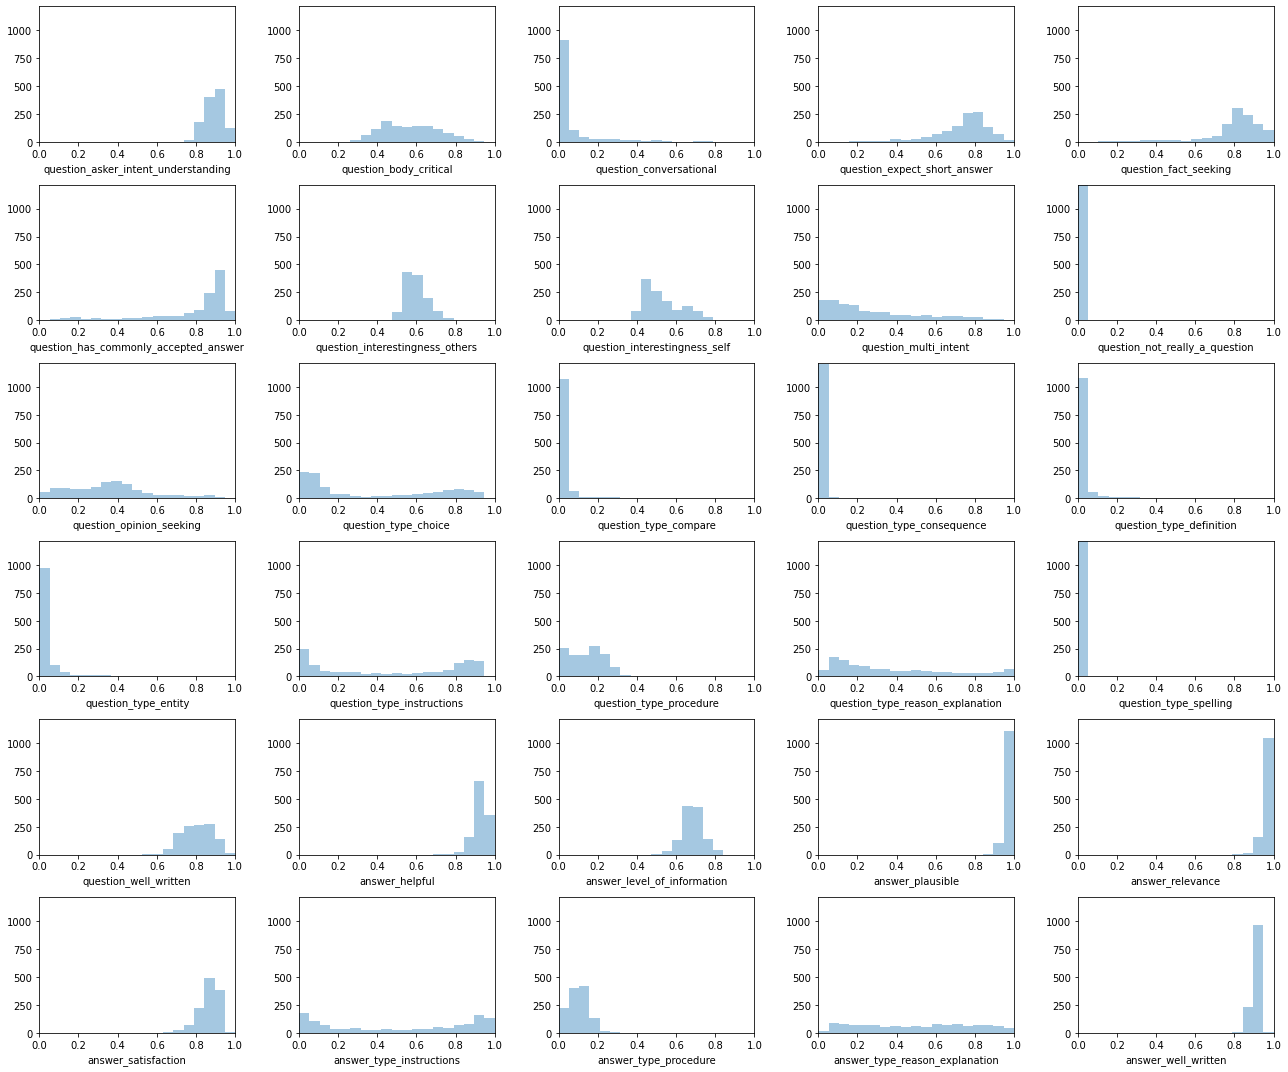

In [113]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(targets):
    ax = axes[i]
    sns.distplot(pred_dataframe[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1216])
plt.tight_layout()
plt.show()
plt.close()

## Distribution of Target variables in Actual Data

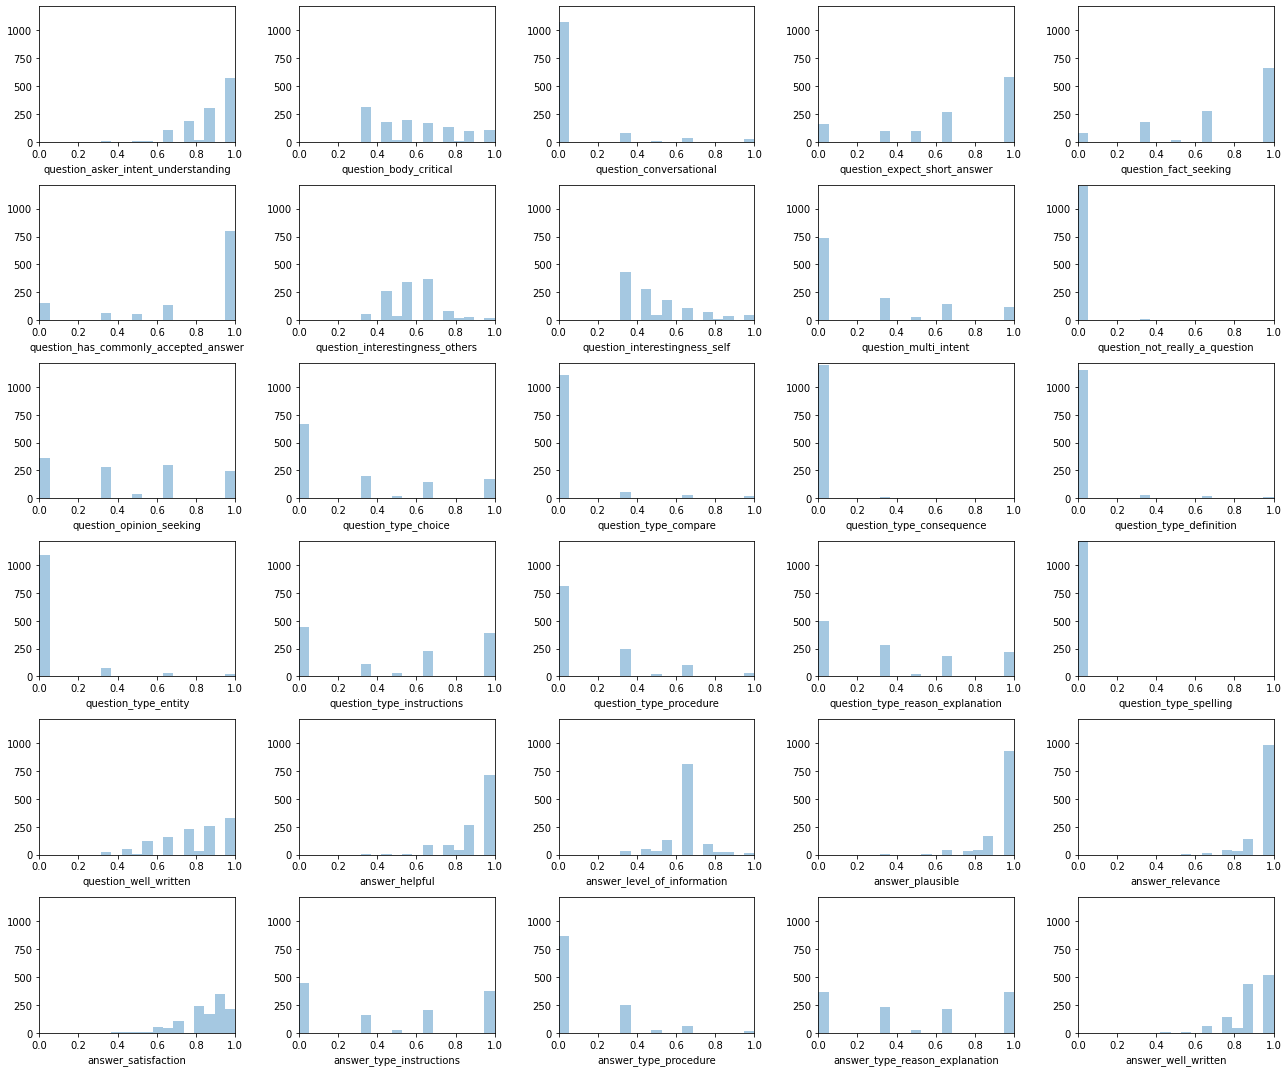

In [114]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(targets):
    ax = axes[i]
    sns.distplot(actual_dataframe[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1216])
plt.tight_layout()
plt.show()
plt.close()

<h2> Conclusion from distribution of predicted and Actual </h2>

1.  Above Plot is a distribution plot of actual and predicted output from the best Bert Model 
2.   From the Distribution we can Conclude that Most of the Feature is Predicted good and thier ranges between 0-1 is almost same .
3. Some Feature like question_fact_seeking ,question_multi_intent is differ by the Range 0.1 otherwise every feature is almost in same range.



In [115]:
print(true_output.shape)
print(predicted_output.shape)

(1216, 30)
(1216, 30)


In [116]:
len(targets)

30

<h2> Spearman Correaltion of Each Feature in a Datapoint </h2>

In [117]:
for i in range(len(targets)):
  print("Spearman Correaltion in Feature {row} ".format(row = i+1),spearmanr(true_output[:, i], predicted_output[:, i]).correlation)
  print("=="*62)

Spearman Correaltion in Feature 1  0.40993690025303725
Spearman Correaltion in Feature 2  0.6404288846769483
Spearman Correaltion in Feature 3  0.46452270891265374
Spearman Correaltion in Feature 4  0.44794321325992564
Spearman Correaltion in Feature 5  0.4802539013110392
Spearman Correaltion in Feature 6  0.5701283805494901
Spearman Correaltion in Feature 7  0.3887799613620518
Spearman Correaltion in Feature 8  0.5495861660647166
Spearman Correaltion in Feature 9  0.6490617935760808
Spearman Correaltion in Feature 10  0.10985602426047784
Spearman Correaltion in Feature 11  0.6246258208058679
Spearman Correaltion in Feature 12  0.7927164093863606
Spearman Correaltion in Feature 13  0.4347532567030249
Spearman Correaltion in Feature 14  0.17863718762349037
Spearman Correaltion in Feature 15  0.362592149532066
Spearman Correaltion in Feature 16  0.4689497017776372
Spearman Correaltion in Feature 17  0.8349960893622543
Spearman Correaltion in Feature 18  0.43162829628339566
Spearman Corre

<h2> Conclusion from Spearman Correaltion of Each Feature in a Datapoint </h2>

The Spearmen Correaltion of Feature qyestion_type_instruction is the best among all and getting 0.83 value. These features is predicting the output pretty well. so We can Conclude that these are the Feature which are contributing to overall mean of spearman value of each data point.
Question_not_really_ question has less value of Spearmen Correaltion of 0.10 and 
Rest all is perfoming pretty good

In [118]:
print(true_output.shape)
print(predicted_output.shape)

(1216, 30)
(1216, 30)


In [119]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
bce = tf.keras.losses.BinaryCrossentropy()

<h2> Getting Mean Squared Error , Mean Absolute Error ,Mean Absolute Percentage Error, Binary Cross Entropy Error in each Data point in Predicted Value</h2> 

In [120]:
for i in range(len(predicted_output)):
  print("Mean Squared Error Error in {row} Data Point".format(row = i+1),mse(predicted_output[i], true_output[i]).numpy())
  print("Mean Absolute Error Error in {row} Data Point".format(row = i+1),mae(predicted_output[i], true_output[i]).numpy())
  print("Mean Absolute Percentage Error Error in {row} Data Point".format(row = i+1),mape(predicted_output[i], true_output[i]).numpy())
  print("Binary Cross Entropy Error in {row} Data Point".format(row = i+1),bce(predicted_output[i], true_output[i]).numpy())
  print("=="*62)


Streaming output truncated to the last 5000 lines.
Mean Absolute Error Error in 217 Data Point 0.12445047497749329
Mean Absolute Percentage Error Error in 217 Data Point 55.72272491455078
Binary Cross Entropy Error in 217 Data Point 1.4689544439315796
Mean Squared Error Error in 218 Data Point 0.04910821467638016
Mean Absolute Error Error in 218 Data Point 0.1230667233467102
Mean Absolute Percentage Error Error in 218 Data Point 54.950096130371094
Binary Cross Entropy Error in 218 Data Point 1.5248781442642212
Mean Squared Error Error in 219 Data Point 0.059019699692726135
Mean Absolute Error Error in 219 Data Point 0.16596929728984833
Mean Absolute Percentage Error Error in 219 Data Point 100.22526550292969
Binary Cross Entropy Error in 219 Data Point 1.2345609664916992
Mean Squared Error Error in 220 Data Point 0.0161060132086277
Mean Absolute Error Error in 220 Data Point 0.08103936910629272
Mean Absolute Percentage Error Error in 220 Data Point 47.42675018310547
Binary Cross Entrop

<h1> Conclusion From Error Analysis of Feature in a Datapoint </h1>

<h2> Conclusion from distribution of predicted and Actual </h2>

1.  Above Plot is a distribution plot of actual and predicted output from the best Bert Model 
2.   From the Distribution we can Conclude that Most of the Feature is Predicted good and thier ranges between 0-1 is almost same .
3. Some Feature like question_fact_seeking ,question_multi_intent is differ by the Range 0.1 otherwise every feature is almost in same range.



<h2> Conclusion from Spearman Correaltion of Each Feature in a Datapoint </h2>

The Spearmen Correaltion of Feature qyestion_type_instruction is the best among all and getting 0.83 value. These features is predicting the output pretty well. so We can Conclude that these are the Feature which are contributing to overall mean of spearman value of each data point.
Question_not_really_ question has less value of Spearmen Correaltion of 0.10 and 
Rest all is perfoming pretty good